## In a previous notebook, we demonstrated how Triglav can be used to calculate feature stability scores. We showed that Triglav will produce a set of stable features. In this notebook, we will run a simple analysis of the gut microbiomes of patients suffering from Crohn's Disease and compare that to healthy controls. We will select a set of non-redundant (one feature per cluster) features using Triglav's first and second stage. Finally, we will demonstrate how Triglav can be used with other tools to analyze which features are important and how these features can explain a sample's location in a projected space. ASVs and taxonomic assignments were created using FASTQ files analyzed with the MetaWorks pipeline (available here: https://github.com/terrimporter/MetaWorks)

#### Import required packages

In [1]:
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.svm import LinearSVC

from TreeOrdination import TreeOrdination

from triglav import Triglav, ETCProx

import shap as sh

import sage as sg

import numpy as np

import pandas as pd

from random import shuffle

import seaborn as sns

from matplotlib import pyplot as plt

from skbio.stats.composition import clr, multiplicative_replacement, closure

from statsmodels.stats.multitest import multipletests

d:\miniconda3\envs\testLM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\miniconda3\envs\testLM\Lib\site-packages\shap\utils\_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
d:\miniconda3\envs\testLM\Lib\site-packages\shap\utils\_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba

#### Read in taxonomic data and select high-confidence ASVs

In [2]:
if __name__ == "__main__":

    #Read in ASV table
    X = pd.read_csv("Diseased Gut/ESV.table", index_col=0, sep="\t")
    X_features = X.index.values #Get features
    X_index = [s_name.split("_")[0] for s_name in X.columns.values] #Get the right index
    X_original = X.transpose()
    X_original.index = X_index #Fix the index so it can be ordered
    
    # Read in taxa data
    taxa_tab = pd.read_csv(
        "Diseased Gut/rdp.out.tmp", delimiter="\t", header=None
    ).values

    #Convert taxa tab into a dictionary for quick searching
    taxa_dict = {t[0]: np.asarray(t)[1:] for t in taxa_tab}
    
    # Keep all ASVs assigned to Bacteria and Archaea, remove Cyanobacteria and Chloroplasts
    idx = np.where(
        ((taxa_tab[:, 2] == "Bacteria") | (taxa_tab[:, 2] == "Archaea")), True, False
    )
    taxa_tab = taxa_tab[idx]
    idx = np.where(taxa_tab[:, 5] != "Cyanobacteria/Chloroplast", True, False)
    taxa_tab = taxa_tab[idx]
    X_selected = set([x[0] for x in taxa_tab])
    taxa_tab_ss = {x[0]: x for x in taxa_tab}

    # Get names of high confidence features
    n_list = [4, 7, 10, 13, 16, 19]
    asv_name = []

    for entry in X_features:
        if entry in taxa_dict:
            if float(taxa_dict[entry][-1]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-3], entry))

            elif float(taxa_dict[entry][-4]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-6], entry))

            elif float(taxa_dict[entry][-7]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-9], entry))

            elif float(taxa_dict[entry][-10]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-12], entry))

            elif float(taxa_dict[entry][-13]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-15], entry))

            else:
                asv_name.append("Unclassified-%s" % entry)
    
    asv_name = np.asarray(asv_name)

In [3]:
    print(asv_name.shape)
    print(X_features.shape)
    print(X_original.shape)
    print(X_original)
    print(asv_name)

(3318,)
(3318,)
(214, 3318)
#OTU ID     Zotu1  Zotu10  Zotu100  Zotu1000  Zotu1001  Zotu1002  Zotu1003   
SRR8534033    926       1        0         0         0         0         0  \
SRR8534034  38586      14        1         0         0         0         0   
SRR8534035  49718    1069        1         0         2         0         0   
SRR8534036   1016     236        0         0         0         0         0   
SRR8534037   4247    3416        0         0         0         0         0   
...           ...     ...      ...       ...       ...       ...       ...   
SRR8534250   5231    2880        0         0         1         0         0   
SRR8534251    636     145        0         0         0         0         0   
SRR8534252   3026     347      332         0         0         0         0   
SRR8534253    111     163        0         0         0         0         0   
SRR8534254  12386    2485        0         0         0         0         0   

#OTU ID     Zotu1004  Zotu1005  Zot

#### Read in metadata and order X

In [4]:
    # Read in metadata
    meta = pd.read_csv("Diseased Gut/metadata.csv", index_col=0)
    meta = meta[["Sample Name", "Host_disease", "Timepoint"]]

    # Correct locations so they are more informative
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "CD", "Crohn's Disease", meta["Host_disease"]
    )
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "RA", "Rheumatoid Arthritis", meta["Host_disease"]
    )
    meta["Host_diseaes"] = np.where(
        meta["Host_disease"] == "MS", "Multiple Sclerosis", meta["Host_disease"]
    )
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "US", "Ulcerative Colitis", meta["Host_disease"]
    )
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "HC", "Healthy Control", meta["Host_disease"]
    )
    
    #Order samples according to the metadata
    X_original = X_original.loc[meta.index]


In [5]:
    print(meta)
    print(X_original)

            Sample Name          Host_disease  Timepoint          Host_diseaes
SRR8534151       1003.1  Rheumatoid Arthritis          1  Rheumatoid Arthritis
SRR8534152       1003.2  Rheumatoid Arthritis          2  Rheumatoid Arthritis
SRR8534149       1021.1  Rheumatoid Arthritis          1  Rheumatoid Arthritis
SRR8534083       1021.2  Rheumatoid Arthritis          2  Rheumatoid Arthritis
SRR8534155       1024.1  Rheumatoid Arthritis          1  Rheumatoid Arthritis
...                 ...                   ...        ...                   ...
SRR8534199       8399.2                    UC          2                    UC
SRR8534200       8407.1       Crohn's Disease          1       Crohn's Disease
SRR8534125       8407.2       Crohn's Disease          2       Crohn's Disease
SRR8534128       8702.1                    UC          1                    UC
SRR8534126       8702.2                    UC          2                    UC

[198 rows x 4 columns]
#OTU ID     Zotu1  Zotu10  Z

#### Get the group metadata (Sample Name)

In [6]:
    # Get groups
    groups = meta["Sample Name"].astype(str).values
    groups = np.asarray([x.split(".")[0] for x in groups])
    
    # List of phenotypes/datasets to test
    pheno = "Crohn's Disease-Healthy Control"

    pheno_a, pheno_b = pheno.split("-")

    idx = np.where(
        ((meta["Host_disease"] == pheno_a) | (meta["Host_disease"] == pheno_b)),
        True,
        False,
    )

    y = meta[idx]["Host_disease"]
    y = y.values
    
    X_signal = X_original[idx]
    
    groups = groups[idx]


In [7]:
    print(y)
    print(groups)
    print(X_signal)

['Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disease" "Crohn's Disease"
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disease" "Crohn's Disease"
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disease" "Crohn's Disease"
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 "Crohn's Disease" "Crohn's Disease" 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disea

#### We want to identify a good depth for trees. This is because identifying the most predictive features is likely to occur at shallow depths. A max depth of 5 seems OK

In [8]:
    # Remove very rare ASVs (<= 4 occurances)
    X_removed = np.where(X_signal.values > 0, True, False)
    occ = np.where(X_removed.sum(axis = 0) > 4, True, False)
    X_removed = X_signal.values[:, occ]
    reduced_features = asv_name[occ]
    
    print("All Features: ", X_signal.shape[1])
    print("Reduced Features: ", X_removed.shape[1])
    
    # Split samples based on disease status and patient number
    splitter = StratifiedGroupKFold(n_splits = 5, random_state = 0, shuffle = True)   
    for train, test in splitter.split(X_signal.values, y, groups):
        
        X_train = X_signal.values[train]
        y_train = y[train]
        
        X_test = X_signal.values[test]
        y_test = y[test]
        
        # Determine the best tree-depth. 
        # We want a shallow depth to avoid poorly discrimative features
        clf = GridSearchCV(estimator = ExtraTreesClassifier(512),
                           param_grid = {"max_depth": [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
                           n_jobs = 5).fit(clr(multiplicative_replacement(closure(X_train))), y_train)
        
        print(clf.best_params_, clf.best_score_)
        


All Features:  3318
Reduced Features:  938
{'max_depth': 8} 0.8128205128205128
{'max_depth': 5} 0.8397435897435898
{'max_depth': None} 0.826923076923077
{'max_depth': 6} 0.8897435897435898
{'max_depth': 6} 0.8602564102564104


#### Define simple transformer function to create CLR transformed data.

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class CLRTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit_transform(self, X):
        
        return clr(multiplicative_replacement(closure(X)))

#### Prepare the nature-based solutions to be tested

In [172]:
    from mealpy.swarm_based import PSO, ABC
    from mealpy.swarm_based.NMRA import ImprovedNMRA
    from mealpy.swarm_based.GWO import GWO_WOA
    from mealpy.utils.logger import Logger
    from mealpy.utils.problem import Problem
    
    from sklearn.svm import LinearSVC
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, cross_validate
    from sklearn.metrics import make_scorer, pairwise_distances
    from sklearn.ensemble import StackingClassifier
    
    from skrebate import MultiSURF
    
    from skbio.stats.distance._cutils import permanova_f_stat_sW_cy
    from skbio.stats.distance._base import _preprocess_input_sng
    from skbio.stats.ordination import pcoa
    from skbio import DistanceMatrix
    
    import warnings
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    
    def f_stat(X, y):
        
        D = DistanceMatrix(pairwise_distances(X, metric = "euclidean").astype(np.float32))
        
        SST = D[:] ** 2
        SST = SST.sum() / X.shape[0]
        SST = SST / 2.0
        
        n_groups, grouping = _preprocess_input_sng(D.ids, X.shape[0], y, None)
        
        grouping = np.asarray(grouping)
        
        group_sizes = np.bincount(grouping)
        
        SSW = permanova_f_stat_sW_cy(DistanceMatrix(D).data,
                                     group_sizes, 
                                     grouping)
        
        SSA = SST - SSW
        
        return (SSW / (X.shape[0] - n_groups)) / (SSA / (n_groups - 1)) # To turn this into a minimization problem
     
    
    class FSProblem(Problem):

        SUPPORTED_ARRAY = (list, tuple, np.ndarray)

        def __init__(self, lb=None, ub=None, minmax="min", X=None, y=None, **kwargs):
            r"""Initialize Problem.

            Args:
                lb (numpy.ndarray, list, tuple): Lower bounds of the problem.
                ub (numpy.ndarray, list, tuple): Upper bounds of the problem.
                minmax (str): Minimization or maximization problem (min, max)
                name (str): Name for this particular problem
            """
            self.name, self.log_to, self.log_file = "P", "console", "history.txt"
            self.n_objs, self.obj_is_list, self.multi_objs = 1, False, False
            self.n_dims, self.lb, self.ub, self.save_population = None, None, None, False
            self.X, self.y = X, y
            self.obj_weights = [0.98, 0.02]

            self.__set_keyword_arguments(kwargs)
            self.__set_domain_range(lb, ub)
            self.__set_functions(kwargs)
            self.logger = Logger(self.log_to, log_file=self.log_file).create_logger(name=f"{__name__}.{__class__.__name__}",
                                        format_str='%(asctime)s, %(levelname)s, %(name)s [line: %(lineno)d]: %(message)s')
            self.minmax = minmax

        def __set_keyword_arguments(self, kwargs):
            for key, value in kwargs.items():
                setattr(self, key, value)

        def __set_domain_range(self, lb, ub):
            if type(lb) in self.SUPPORTED_ARRAY and type(ub) in self.SUPPORTED_ARRAY:
                self.lb = np.array(lb).flatten()
                self.ub = np.array(ub).flatten()
                if len(self.lb) == len(self.ub):
                    self.n_dims = len(self.lb)
                    if len(self.lb) < 1:
                        raise ValueError(f'Dimensions do not qualify. Length(lb) = {len(self.lb)} < 1.')
                else:
                    raise ValueError(f"Length of lb and ub do not match. {len(self.lb)} != {len(self.ub)}.")
            else:
                raise ValueError(f"lb and ub need to be a list, tuple or np.array.")

        def __set_functions(self, kwargs):
            tested_solution = self.generate_position(self.lb, self.ub)
            if "amend_position" in kwargs:
                if not callable(self.amend_position):
                    raise ValueError(f"Use default 'amend_position()' or passed a callable function. {type(self.amend_position)} != function")
                else:
                    tested_solution = self.amend_position(tested_solution, self.lb, self.ub)
            result = self.fit_func(tested_solution)
            if type(result) in self.SUPPORTED_ARRAY:
                result = np.array(result).flatten()
                self.n_objs = len(result)
                self.obj_is_list = True
                if self.n_objs > 1:
                    self.multi_objs = True
                    if type(self.obj_weights) in self.SUPPORTED_ARRAY:
                        self.obj_weights = np.array(self.obj_weights).flatten()
                        if self.n_objs != len(self.obj_weights):
                            raise ValueError(f"{self.n_objs}-objective problem, but N weights = {len(self.obj_weights)}.")
                        self.msg = f"Solving {self.n_objs}-objective optimization problem with weights: {self.obj_weights}."
                    else:
                        raise ValueError(f"Solving {self.n_objs}-objective optimization, need to set obj_weights list with length: {self.n_objs}")
                elif self.n_objs == 1:
                    self.multi_objs = False
                    self.obj_weights = np.ones(1)
                    self.msg = f"Solving single objective optimization problem."
                else:
                    raise ValueError(f"fit_func needs to return a single value or a list of values list")
            elif type(result) in (int, float) or isinstance(result, np.floating) or isinstance(result, np.integer):
                self.multi_objs = False
                self.obj_is_list = False
                self.obj_weights = np.ones(1)
                self.msg = f"Solving single objective optimization problem."
            else:
                raise ValueError(f"fit_func needs to return a single value or a list of values list")

        def fit_func(self, x):
            """Fitness function

            Args:
                x (numpy.ndarray): Solution.

            Returns:
                float: Function value of `x`.
            """
            selected = x > 0.4
            
            num_selected = selected.sum()
            if num_selected == 0:
                return 1.0           
            
            if num_selected > 100:
                n_to_select = 100
                
            else:
                n_to_select = int(num_selected * 0.8)
                
            # Select an initial group of features
            x_train = self.X[:, selected].astype(float)
                
            # Split data and train
            c1 = ["et", ExtraTreesClassifier(128, max_depth = 5)]
            c2 = ["lc", LogisticRegressionCV(max_iter = 1000)]
            
            c3 = StackingClassifier([c1, c2])
            
            c4 = cross_val_score(c3, x_train, self.y, cv = 3, scoring = make_scorer(balanced_accuracy_score), n_jobs = 3)
                
            # Score          
            score = 1 - c4.mean()

            num_features = self.X.shape[1]          
            f_frac = num_selected / num_features
            
            o_1 = (0.99*score) + ((0.01)*f_frac)
            o_2 = (0.99*f_stat(x_train, self.y)) + ((0.01)*f_frac)
            
            return o_1, o_2

        def get_name(self):
            """
            Returns:
                string: The name of the problem
            """
            return self.name

        def get_class_name(self):
            """Get class name."""
            return self.__class__.__name__

        def generate_position(self, lb=None, ub=None):
            """
            Generate the position depends on the problem. For discrete problem such as permutation, this method can be override.

            Args:
                lb: list of lower bound values
                ub: list of upper bound values

            Returns:
                np.array: the position (the solution for the problem)
            """
            return np.random.uniform(lb, ub)

        def amend_position(self, position=None, lb=None, ub=None):
            """
            The goal is to transform the solution into the right format corresponding to the problem.
            For example, with discrete problems, floating-point numbers must be converted to integers
            to ensure the solution is in the correct format.

            Args:
                position: vector position (location) of the solution.
                lb: list of lower bound values
                ub: list of upper bound values

            Returns:
                Amended position (make the right format of the solution)
            """
            return position
        
  
 
    from sklearn.utils import resample
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import log_loss
    class DSFSProblem(Problem):

        SUPPORTED_ARRAY = (list, tuple, np.ndarray)

        def __init__(self, lb=None, ub=None, minmax="min", X=None, y=None, **kwargs):
            r"""Initialize Problem.

            Args:
                lb (numpy.ndarray, list, tuple): Lower bounds of the problem.
                ub (numpy.ndarray, list, tuple): Upper bounds of the problem.
                minmax (str): Minimization or maximization problem (min, max)
                name (str): Name for this particular problem
            """
            self.name, self.log_to, self.log_file = "P", "console", "history.txt"
            self.n_objs, self.obj_is_list, self.multi_objs = 1, False, False
            self.n_dims, self.lb, self.ub, self.save_population = None, None, None, False
            self.X, self.y = X, y
            self.obj_weights = [0.6, 0.4]

            self.__set_keyword_arguments(kwargs)
            self.__set_domain_range(lb, ub)
            self.__set_functions(kwargs)
            self.logger = Logger(self.log_to, log_file=self.log_file).create_logger(name=f"{__name__}.{__class__.__name__}",
                                        format_str='%(asctime)s, %(levelname)s, %(name)s [line: %(lineno)d]: %(message)s')
            self.minmax = minmax

        def __set_keyword_arguments(self, kwargs):
            for key, value in kwargs.items():
                setattr(self, key, value)

        def __set_domain_range(self, lb, ub):
            if type(lb) in self.SUPPORTED_ARRAY and type(ub) in self.SUPPORTED_ARRAY:
                self.lb = np.array(lb).flatten()
                self.ub = np.array(ub).flatten()
                if len(self.lb) == len(self.ub):
                    self.n_dims = len(self.lb)
                    if len(self.lb) < 1:
                        raise ValueError(f'Dimensions do not qualify. Length(lb) = {len(self.lb)} < 1.')
                else:
                    raise ValueError(f"Length of lb and ub do not match. {len(self.lb)} != {len(self.ub)}.")
            else:
                raise ValueError(f"lb and ub need to be a list, tuple or np.array.")

        def __set_functions(self, kwargs):
            tested_solution = self.generate_position(self.lb, self.ub)
            if "amend_position" in kwargs:
                if not callable(self.amend_position):
                    raise ValueError(f"Use default 'amend_position()' or passed a callable function. {type(self.amend_position)} != function")
                else:
                    tested_solution = self.amend_position(tested_solution, self.lb, self.ub)
            result = self.fit_func(tested_solution)
            if type(result) in self.SUPPORTED_ARRAY:
                result = np.array(result).flatten()
                self.n_objs = len(result)
                self.obj_is_list = True
                if self.n_objs > 1:
                    self.multi_objs = True
                    if type(self.obj_weights) in self.SUPPORTED_ARRAY:
                        self.obj_weights = np.array(self.obj_weights).flatten()
                        if self.n_objs != len(self.obj_weights):
                            raise ValueError(f"{self.n_objs}-objective problem, but N weights = {len(self.obj_weights)}.")
                        self.msg = f"Solving {self.n_objs}-objective optimization problem with weights: {self.obj_weights}."
                    else:
                        raise ValueError(f"Solving {self.n_objs}-objective optimization, need to set obj_weights list with length: {self.n_objs}")
                elif self.n_objs == 1:
                    self.multi_objs = False
                    self.obj_weights = np.ones(1)
                    self.msg = f"Solving single objective optimization problem."
                else:
                    raise ValueError(f"fit_func needs to return a single value or a list of values list")
            elif type(result) in (int, float) or isinstance(result, np.floating) or isinstance(result, np.integer):
                self.multi_objs = False
                self.obj_is_list = False
                self.obj_weights = np.ones(1)
                self.msg = f"Solving single objective optimization problem."
            else:
                raise ValueError(f"fit_func needs to return a single value or a list of values list")

        def fit_func(self, x):
            """Fitness function

            Args:
                x (numpy.ndarray): Solution.

            Returns:
                float: Function value of `x`.
            """
            selected = x > 0
            
            num_selected = selected.sum()
            if num_selected == 0:
                return 1.0           
                
            # Subset
            x_train = self.X[:, selected].astype(float)
                
            # Train
            c1 = cross_validate(ExtraTreesClassifier(128, max_depth = 3), 
                               x_train, self.y, 
                               cv = 3, 
                               scoring = "balanced_accuracy",
                               return_estimator = True,
                               return_indices = True,
                               n_jobs = 5)
            
            test_ind = [inds for inds in c1["indices"]["test"]]
            log_losses_1 = [log_loss(self.y[test_ind[i]], c1["estimator"][i].predict_proba(x_train[test_ind[i]])) for i in range(3)]
            log_losses_1 = np.asarray(log_losses_1).mean()
            
            # Score
            s_1 = 1 - c1["test_score"].mean()
            s_2 = np.asarray(log_losses_1).mean()
            s_3 = f_stat(x_train, self.y)
            score = 1.0 - s_1

            num_features = self.X.shape[1]          
            f_frac = num_selected / num_features

            o_1 = (0.85 * s_1) + (0.10 * s_2) + (0.05 * s_3)
            o_4 = f_frac
            
            return o_1, o_4

        def get_name(self):
            """
            Returns:
                string: The name of the problem
            """
            return self.name

        def get_class_name(self):
            """Get class name."""
            return self.__class__.__name__

        def generate_position(self, lb=None, ub=None):
            """
            Generate the position depends on the problem. For discrete problem such as permutation, this method can be override.

            Args:
                lb: list of lower bound values
                ub: list of upper bound values

            Returns:
                np.array: the position (the solution for the problem)
            """
            pos = np.random.uniform(lb, ub)
            pos = np.where(pos > 0.4, 1, 0)
            
            return pos

        def amend_position(self, position=None, lb=None, ub=None):
            """
            The goal is to transform the solution into the right format corresponding to the problem.
            For example, with discrete problems, floating-point numbers must be converted to integers
            to ensure the solution is in the correct format.

            Args:
                position: vector position (location) of the solution.
                lb: list of lower bound values
                ub: list of upper bound values

            Returns:
                Amended position (make the right format of the solution)
            """
            position_clipped = np.where(position > 0.4, 1, 0)
            
            return position_clipped
    
    

#### Test to see if there are differences between algorithms

In [176]:
    def map_back_to_orig(idx_original, best_features_1, best_features_2, stage_2 = False):
        
        # Get final size of feature selection vector
        final_vec = np.zeros(shape = (idx_original.shape[0]), dtype = np.int8)
        
        # Subset indicies of each feature by the first set of selected features
        sel = idx_original[best_features_1]
        
        # Subset indicies of the subset by the second set of selected features (if applicable)
        if stage_2:
            sel = sel[best_features_2]
          
        # Loop through each remaining index and update the feature selection vector (1 if selected)
        for idx in sel:
            final_vec[idx] = 1
            
        return final_vec
    
    # Import other FS algorithms
    from sklearn.feature_selection import SelectKBest, SelectFdr, RFE, RFECV, mutual_info_classif, f_classif
    from boruta import BorutaPy
    
    tmp_base = []

    idx_original_vec = np.asarray([i for i in range(X_removed.shape[1])])
    
    # Test population size
    for i in range(5):
        print(i)
        
        splitter = StratifiedGroupKFold(n_splits = 5, random_state = i, shuffle = True)
        
        for train, test in splitter.split(X_removed, y, groups):
            
            X_train = X_removed[train]
            y_train = y[train]
            
            X_test = X_removed[test]
            y_test = y[test]
            
            tg_model = Triglav(n_jobs = 15,
                       estimator = ExtraTreesClassifier(512, max_depth = 10, bootstrap = True), # Bootstrap is set to true to increase randomization
                       verbose = 3,
                       n_iter_fwer = 5, # A lower value will result in a more conservative selection of clusters
                       p_1 = 0.7, # A higher value will result in a more conservative selection of clusters
                       p_2 = 0.4, # A higher value will result in more clusters being rejected
                       metric = "correlation",
                       linkage = "complete",
                       transformer = CLRTransformer(),
                       run_stage_2 = False, 
                       alpha = 0.05, # A lower value will result in a more conservative selection of clusters
                       thresh = 0.5) # This value will control the number of clusters.

            tg_model.fit(X_train, y_train)
            
            # Create a subset of the training data using Triglav selected features
            X_train_tr = CLRTransformer().fit_transform(X_train[:, tg_model.selected_])
            X_test_tr = CLRTransformer().fit_transform(X_test[:, tg_model.selected_])
            
            # CLR transform training data
            X_train = CLRTransformer().fit_transform(X_train)
            X_test = CLRTransformer().fit_transform(X_test)
             
            # Control (Positive) - No Feature Selection
            clf = ExtraTreesClassifier(512).fit(X_train, y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train, y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test))
            
            print("Control (Positive)", ba, ba2, X_train.shape[1])
            
            tmp_base.append(("Control (Positive)",
                             ba, ba2,
                             "NA", 
                             X_train.shape[1]))
            
            # Control (Negative) - No Feature Selection
            random_y_idx = np.random.permutation(y_train.shape[0])
            
            clf = ExtraTreesClassifier(512).fit(X_train, y_train[random_y_idx])
            ba = balanced_accuracy_score(y_test, clf.predict(X_test))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train, y_train[random_y_idx])
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test))
            
            print("Control (Negative)", ba, ba2, X_train.shape[1])
            
            tmp_base.append(("Control (Negative)",
                             ba, ba2,
                             "NA", 
                             X_train.shape[1])) 
            
            # ANOVA
            anova_model = SelectFdr(alpha = 0.05).fit(X_train, y_train)
            f_sel = anova_model.get_support()
     
            clf = ExtraTreesClassifier(512).fit(anova_model.transform(X_train), y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(anova_model.transform(X_test)))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(anova_model.transform(X_train), y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(anova_model.transform(X_test)))
            
            print("ANOVA", "Base", ba, ba2, f_sel.sum())
            
            tmp_base.append(("ANOVA",
                             ba, ba2,
                             f_sel, 
                             f_sel.sum())) 
            
            # MI
            for n_select in [10, 20, 40, 60, 80, 100]:
                mi_model = SelectKBest(score_func = mutual_info_classif, k = n_select).fit(X_train, y_train)
                f_sel = mi_model.get_support()

                clf = ExtraTreesClassifier(512).fit(mi_model.transform(X_train), y_train)
                ba = balanced_accuracy_score(y_test, clf.predict(mi_model.transform(X_test)))

                clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                        dual = "auto"),
                                  param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                                  cv = 5,
                                  scoring = make_scorer(balanced_accuracy_score),
                                  n_jobs = -1).fit(mi_model.transform(X_train), y_train)
                ba2 = balanced_accuracy_score(y_test, clf2.predict(mi_model.transform(X_test)))

                print("Mutual Information (%d)" %n_select, "Base", ba, ba2, f_sel.sum())

                tmp_base.append(("Mutual Information (%d)" %n_select,
                                 ba, ba2,
                                 f_sel, 
                                 f_sel.sum())) 
            
                # RFE
                rfe_model = RFE(estimator = ExtraTreesClassifier(512),
                                n_features_to_select = n_select,
                                step = 0.05).fit(X_train, y_train)

                f_sel = rfe_model.get_support()

                ba = balanced_accuracy_score(y_test, rfe_model.predict(X_test))

                clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                        dual = "auto"),
                                  param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                                  cv = 5,
                                  scoring = make_scorer(balanced_accuracy_score),
                                  n_jobs = -1).fit(rfe_model.transform(X_train), y_train)
                ba2 = balanced_accuracy_score(y_test, clf2.predict(rfe_model.transform(X_test)))

                print("RFE (%d)" %n_select, "Base", ba, ba2, f_sel.sum())

                tmp_base.append(("RFE (%d)" %n_select,
                                 ba, ba2,
                                 f_sel, 
                                 f_sel.sum()))
                
                # MultiSURF
                f_selector = MultiSURF(n_features_to_select = n_select,
                                  n_jobs = 4).fit(X_train.astype(float), 
                                                  y_train)

                clf = ExtraTreesClassifier(512).fit(f_selector.transform(X_train), y_train)
                ba = balanced_accuracy_score(y_test, clf.predict(f_selector.transform(X_test)))

                best_features = f_selector.transform(np.asarray([idx_original_vec]))[0]

                f_sel = map_back_to_orig(idx_original_vec, best_features, None, stage_2 = False)

                clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                        dual = "auto"),
                                  param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                                  cv = 5,
                                  scoring = make_scorer(balanced_accuracy_score),
                                  n_jobs = -1).fit(f_selector.transform(X_train), y_train)
                ba2 = balanced_accuracy_score(y_test, clf2.predict(f_selector.transform(X_test)))

                print("MultiSURF (%d)" %n_select, ba, ba2, f_sel.sum())
                tmp_base.append(("MultiSURF (%d)" %n_select,
                                 ba, ba2,
                                 f_sel, 
                                 f_sel.sum()))
            
            # RFECV
            rfe_model = RFECV(estimator = ExtraTreesClassifier(512),
                              step = 0.05,
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = 5
                              ).fit(X_train, y_train)
            
            f_sel = rfe_model.get_support()
            
            ba = balanced_accuracy_score(y_test, rfe_model.predict(X_test))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train[:, f_sel], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test[:, f_sel]))
            
            print("RFECV", "Base", ba, ba2, f_sel.sum())
            tmp_base.append(("RFECV",
                             ba, ba2,
                             f_sel, 
                             f_sel.sum()))
            
            # Boruta
            boruta_model = BorutaPy(ExtraTreesClassifier(), n_estimators = 128, verbose = 0)
            boruta_model.fit(X_train, y_train)
            
            clf = ExtraTreesClassifier(512).fit(boruta_model.transform(X_train), y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(boruta_model.transform(X_test)))
            
            best_features = boruta_model.transform(np.asarray([idx_original_vec]))[0]
            
            f_sel = map_back_to_orig(idx_original_vec, best_features, None, stage_2 = False)
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(boruta_model.transform(X_train), y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(boruta_model.transform(X_test)))
            
            print("Boruta", "Base", ba, ba2, f_sel.sum())
            tmp_base.append(("Boruta",
                             ba, ba2,
                             f_sel, 
                             f_sel.sum()))           
           
            # ABC
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train, 
                                              y= y_train)

            model = ABC.OriginalABC(epoch = 20, n_limits = 10, pop_size = 30)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4
            
            clf = ExtraTreesClassifier(512).fit(X_train[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test[:, best_features]))

            f_sel = map_back_to_orig(idx_original_vec, best_features, None, stage_2 = False)
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test[:, best_features]))
            
            print("Artificial Bee Colony", "Base", ba, ba2, best_features.sum())
            tmp_base.append(("Artificial Bee Colony",
                             ba, ba2,
                             f_sel, 
                             best_features.sum()))

            # PSO
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train, 
                                              y= y_train)

            model = PSO.OriginalPSO(epoch = 20, pop_size = 30)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4

            clf = ExtraTreesClassifier(512).fit(X_train[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test[:, best_features]))

            f_sel = map_back_to_orig(idx_original_vec, best_features, None, stage_2 = False)
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test[:, best_features]))
            
            print("Particle Swarm Optimization", "Base", ba, ba2, best_features.sum())
            tmp_base.append(("Particle Swarm Optimization",
                             ba, ba2,
                             f_sel,
                             best_features.sum()))
            
            # GWO-WOA
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train, 
                                              y= y_train)
    
            model = GWO_WOA(epoch = 20, pop_size = 30)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4
            
            clf = ExtraTreesClassifier(512).fit(X_train[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test[:, best_features]))

            f_sel = map_back_to_orig(idx_original_vec, best_features, None, stage_2 = False)
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test[:, best_features]))
            
            print("Gray Wolf - Whale Optimization Algorithm", "Base", ba, ba2, best_features.sum())
            
            tmp_base.append(("Gray Wolf - Whale Optimization Algorithm",
                             ba, ba2,
                             f_sel,
                             best_features.sum()))
            
            # Naked Mole Rat Algorithm
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train, 
                                              y= y_train)
    
            model = ImprovedNMRA(epoch = 20, pop_size = 30)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4
            
            clf = ExtraTreesClassifier(512).fit(X_train[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test[:, best_features]))

            f_sel = map_back_to_orig(idx_original_vec, best_features, None, stage_2 = False)
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test[:, best_features]))
            
            print("Naked Mole Rat Algorithm", "Base", ba, ba2, best_features.sum())
            
            tmp_base.append(("Naked Mole Rat Algorithm",
                             ba, ba2,
                             f_sel,
                             best_features.sum()))
                            
            # Triglav Stage 1
            clf = ExtraTreesClassifier(512).fit(X_train_tr, y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test_tr))

            f_sel = map_back_to_orig(idx_original_vec, tg_model.selected_, None, stage_2 = False)
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train_tr, y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test_tr))
            
            print("Triglav Stage 1", "Base", ba, ba2, tg_model.selected_.sum())
            
            tmp_base.append(("Triglav Stage 1",
                             ba, ba2,
                             f_sel, 
                             tg_model.selected_.sum())) 
            
            # Triglav Stage 2 - MultiSURF Only
            for n_select in [10, 20, 40, 60, 80, 100]:
                f_selector = MultiSURF(n_features_to_select = n_select,
                                  n_jobs = 4).fit(X_train_tr.astype(float), 
                                                  y_train)

                clf = ExtraTreesClassifier(512).fit(f_selector.transform(X_train_tr), y_train)
                ba = balanced_accuracy_score(y_test, clf.predict(f_selector.transform(X_test_tr)))

                best_features = f_selector.transform(np.asarray([idx_original_vec]))[0]

                f_sel = map_back_to_orig(idx_original_vec, tg_model.selected_, best_features, True)

                clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                        dual = "auto"),
                                  param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                                  cv = 5,
                                  scoring = make_scorer(balanced_accuracy_score),
                                  n_jobs = -1).fit(f_selector.transform(X_train_tr), y_train)
                ba2 = balanced_accuracy_score(y_test, clf2.predict(f_selector.transform(X_test_tr)))

                print("Triglav MultiSURF %d" %n_select, ba, ba2, f_sel.sum())

                tmp_base.append(("Triglav MultiSURF %d" %n_select,
                                 ba, ba2,
                                 f_sel, 
                                 f_sel.sum()))  
                
            # Triglav Stage 2 - ABC
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train_tr.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train_tr.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train_tr, 
                                              y= y_train)

            model = ABC.OriginalABC(epoch = 20, pop_size = 30, n_limits = 10)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4

            clf = ExtraTreesClassifier(512).fit(X_train_tr[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test_tr[:, best_features]))

            f_sel = map_back_to_orig(idx_original_vec, tg_model.selected_, best_features, True)
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train_tr[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test_tr[:, best_features]))
            
            print("Triglav - Artificial Bee Colony", ba, ba2, best_features.sum())
            
            tmp_base.append(("Triglav - Artificial Bee Colony",
                             ba, ba2,
                             f_sel, 
                             best_features.sum()))

            # Triglav Stage 2 - PSO
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train_tr.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train_tr.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train_tr, 
                                              y= y_train)

            model = PSO.OriginalPSO(epoch = 20, pop_size = 30)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4

            clf = ExtraTreesClassifier(512).fit(X_train_tr[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test_tr[:, best_features]))

            f_sel = map_back_to_orig(idx_original_vec, tg_model.selected_, best_features, True)
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train_tr[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test_tr[:, best_features]))
            
            print("Triglav - Particle Swarm Optimization", ba, ba2, best_features.sum())
            
            tmp_base.append(("Triglav - Particle Swarm Optimization",
                             ba, ba2,
                             f_sel,
                             best_features.sum()))
            
            # Triglav GWO-WOA
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train_tr.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train_tr.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train_tr, 
                                              y= y_train)
    
            model = GWO_WOA(epoch = 20, pop_size = 30)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4
            
            clf = ExtraTreesClassifier(512).fit(X_train_tr[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test_tr[:, best_features]))

            f_sel = map_back_to_orig(idx_original_vec, tg_model.selected_, best_features, stage_2 = True)
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train_tr[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test_tr[:, best_features]))
            
            print("Triglav Gray Wolf/Whale Optimization Algorithm", ba, ba2, best_features.sum())
            
            tmp_base.append(("Triglav - Gray Wolf/Whale Optimization Algorithm",
                             ba, ba2,
                             f_sel,
                             best_features.sum()))
            
            # Triglav Naked Mole Rat Algorithm
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train_tr.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train_tr.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train_tr, 
                                              y= y_train)
    
            model = ImprovedNMRA(epoch = 20, pop_size = 30)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4
            
            clf = ExtraTreesClassifier(512).fit(X_train_tr[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test_tr[:, best_features]))

            f_sel = map_back_to_orig(idx_original_vec, tg_model.selected_, best_features, stage_2 = True)
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train_tr[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test_tr[:, best_features]))
            
            print("triglav - Naked Mole Rat Algorithm", ba, ba2, best_features.sum())
            
            tmp_base.append(("Triglav = Naked Mole Rat Algorithm",
                             ba, ba2,
                             f_sel,
                             best_features.sum()))


0
Stage One: Identifying an initial set of tentative features...
Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 451 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 451 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 451 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 451 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 451 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 451 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 

2023/10/14 05:30:38 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 05:31:00 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.30149853671227406, Global best: 0.30149853671227406, Runtime: 13.60535 seconds
2023/10/14 05:31:13 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.30149853671227406, Global best: 0.30149853671227406, Runtime: 13.58549 seconds
2023/10/14 05:31:27 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.30149853671227406, Global best: 0.30149853671227406, Runtime: 13.70401 seconds
2023/10/14 05:31:42 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3095490160850194, Global best: 0.30149853671227406, Runtime: 14.74204 seconds
2023/10/14 05:31:56 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.3121417453332649, Globa

Artificial Bee Colony Base 0.8333333333333333 0.7333333333333334 555


2023/10/14 05:35:40 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 05:35:54 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3123322156701373, Global best: 0.3123322156701373, Runtime: 6.79214 seconds
2023/10/14 05:36:01 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3123322156701373, Global best: 0.3123322156701373, Runtime: 6.87658 seconds
2023/10/14 05:36:08 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.30977474850128234, Global best: 0.30977474850128234, Runtime: 6.83535 seconds
2023/10/14 05:36:15 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.30977474850128234, Global best: 0.30977474850128234, Runtime: 6.75322 seconds
2023/10/14 05:36:22 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3081045387540174, Global best:

Particle Swarm Optimization Base 0.8333333333333333 0.7333333333333334 531


2023/10/14 05:38:09 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 05:38:23 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3033289397956471, Global best: 0.3033289397956471, Runtime: 6.75795 seconds
2023/10/14 05:38:29 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3029008469015114, Global best: 0.3029008469015114, Runtime: 6.71152 seconds
2023/10/14 05:38:36 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3029008469015114, Global best: 0.3029008469015114, Runtime: 6.86911 seconds
2023/10/14 05:38:43 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3029008469015114, Global best: 0.3029008469015114, Runtime: 6.84146 seconds
2023/10/14 05:38:50 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3029008469015114, Global best: 0.3029008469015114, Runtime

Gray Wolf - Whale Optimization Algorithm Base 0.8333333333333333 0.7333333333333334 544


2023/10/14 05:40:36 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 05:40:51 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.2954582062235067, Global best: 0.2954582062235067, Runtime: 6.93702 seconds
2023/10/14 05:40:58 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.2954582062235067, Global best: 0.2954582062235067, Runtime: 6.84689 seconds
2023/10/14 05:41:05 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2867023424741188, Global best: 0.2867023424741188, Runtime: 6.88554 seconds
2023/10/14 05:41:12 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2867023424741188, Global best: 0.2867023424741188, Runtime: 6.90014 seconds
2023/10/14 05:41:18 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.2837270390095987, Glob

Naked Mole Rat Algorithm Base 0.8333333333333333 0.6833333333333333 523
Triglav Stage 1 Base 0.7833333333333333 0.7333333333333334 272
Triglav MultiSURF 10 0.7333333333333334 0.7833333333333333 10
Triglav MultiSURF 20 0.7833333333333333 0.7833333333333333 20
Triglav MultiSURF 40 0.8333333333333333 0.7833333333333333 40
Triglav MultiSURF 60 0.7833333333333333 0.7833333333333333 60
Triglav MultiSURF 80 0.7833333333333333 0.7833333333333333 80
Triglav MultiSURF 100 0.7833333333333333 0.7833333333333333 100


2023/10/14 05:43:30 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 05:43:50 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.2908916610270654, Global best: 0.2908916610270654, Runtime: 13.28945 seconds
2023/10/14 05:44:03 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.2908916610270654, Global best: 0.2908916610270654, Runtime: 13.07839 seconds
2023/10/14 05:44:17 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.29168068525296154, Global best: 0.2908916610270654, Runtime: 13.59769 seconds
2023/10/14 05:44:30 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.29168068525296154, Global best: 0.2908916610270654, Runtime: 13.46617 seconds
2023/10/14 05:44:44 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.2870834286704797, Global bes

Triglav - Artificial Bee Colony 0.8333333333333333 0.7333333333333334 142


2023/10/14 05:48:17 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 05:48:31 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.2914091813255959, Global best: 0.2914091813255959, Runtime: 6.65873 seconds
2023/10/14 05:48:38 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.2914091813255959, Global best: 0.2914091813255959, Runtime: 6.67589 seconds
2023/10/14 05:48:44 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.2914091813255959, Global best: 0.2914091813255959, Runtime: 6.64737 seconds
2023/10/14 05:48:51 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.2914091813255959, Global best: 0.2914091813255959, Runtime: 6.49848 seconds
2023/10/14 05:48:57 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.2914091813255959, Global best: 0.2

Triglav - Particle Swarm Optimization 0.7833333333333333 0.7333333333333334 134


2023/10/14 05:50:40 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 05:50:54 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.28547031997542716, Global best: 0.28547031997542716, Runtime: 6.59557 seconds
2023/10/14 05:51:00 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.28547031997542716, Global best: 0.28547031997542716, Runtime: 6.47169 seconds
2023/10/14 05:51:07 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.28547031997542716, Global best: 0.28547031997542716, Runtime: 6.50393 seconds
2023/10/14 05:51:13 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.28547031997542716, Global best: 0.28547031997542716, Runtime: 6.47963 seconds
2023/10/14 05:51:20 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.28547031997542716, Global best: 0.2854703199754271

Triglav Gray Wolf/Whale Optimization Algorithm 0.7833333333333333 0.7333333333333334 139


2023/10/14 05:53:02 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 05:53:16 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.28424988437041576, Global best: 0.28424988437041576, Runtime: 6.55841 seconds
2023/10/14 05:53:22 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.2771117351591761, Global best: 0.2771117351591761, Runtime: 6.54859 seconds
2023/10/14 05:53:29 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2771117351591761, Global best: 0.2771117351591761, Runtime: 6.52401 seconds
2023/10/14 05:53:35 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2771117351591761, Global best: 0.2771117351591761, Runtime: 6.51978 seconds
2023/10/14 05:53:42 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.2769570075229286, Gl

triglav - Naked Mole Rat Algorithm 0.7833333333333333 0.65 126
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 475 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 475 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 475 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 475 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 475 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 475 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 475 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/14 06:04:25 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 06:04:46 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.33291992561803374, Global best: 0.33291992561803374, Runtime: 13.84535 seconds
2023/10/14 06:05:00 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.33291992561803374, Global best: 0.33291992561803374, Runtime: 13.82170 seconds
2023/10/14 06:05:14 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.33291992561803374, Global best: 0.33291992561803374, Runtime: 13.70535 seconds
2023/10/14 06:05:28 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.33291992561803374, Global best: 0.33291992561803374, Runtime: 14.69634 seconds
2023/10/14 06:05:43 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.34264462397777246, Glo

Artificial Bee Colony Base 0.95 0.95 562


2023/10/14 06:09:29 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 06:09:43 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3320249975230765, Global best: 0.3320249975230765, Runtime: 6.79687 seconds
2023/10/14 06:09:50 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3320249975230765, Global best: 0.3320249975230765, Runtime: 6.93416 seconds
2023/10/14 06:09:57 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3320249975230765, Global best: 0.3320249975230765, Runtime: 6.85514 seconds
2023/10/14 06:10:04 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3320249975230765, Global best: 0.3320249975230765, Runtime: 6.79300 seconds
2023/10/14 06:10:11 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3320249975230765, Global best: 0.3

Particle Swarm Optimization Base 0.95 0.9 534


2023/10/14 06:11:58 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 06:12:13 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3234101421974867, Global best: 0.3234101421974867, Runtime: 6.82444 seconds
2023/10/14 06:12:19 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.31860566320658923, Global best: 0.31860566320658923, Runtime: 6.87590 seconds
2023/10/14 06:12:26 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.31860566320658923, Global best: 0.31860566320658923, Runtime: 6.85187 seconds
2023/10/14 06:12:33 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.31860566320658923, Global best: 0.31860566320658923, Runtime: 6.73489 seconds
2023/10/14 06:12:40 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.31860566320658923, Global best: 0.31860566320658923,

Gray Wolf - Whale Optimization Algorithm Base 0.95 0.95 563


2023/10/14 06:14:28 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 06:14:42 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.31319758675227294, Global best: 0.31319758675227294, Runtime: 6.82769 seconds
2023/10/14 06:14:50 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.31319758675227294, Global best: 0.31319758675227294, Runtime: 7.05259 seconds
2023/10/14 06:14:56 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.30244807272301477, Global best: 0.30244807272301477, Runtime: 6.85337 seconds
2023/10/14 06:15:03 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.30244807272301477, Global best: 0.30244807272301477, Runtime: 6.85680 seconds
2023/10/14 06:15:10 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.30244807272301

Naked Mole Rat Algorithm Base 0.95 0.9 540
Triglav Stage 1 Base 0.8666666666666667 0.95 276
Triglav MultiSURF 10 0.8666666666666667 0.8333333333333333 10
Triglav MultiSURF 20 0.8666666666666667 0.8333333333333333 20
Triglav MultiSURF 40 0.8666666666666667 0.95 40
Triglav MultiSURF 60 0.8666666666666667 0.95 60
Triglav MultiSURF 80 0.8666666666666667 0.8666666666666667 80
Triglav MultiSURF 100 0.8666666666666667 0.8666666666666667 100


2023/10/14 06:17:24 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 06:17:45 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3063314793169349, Global best: 0.3063314793169349, Runtime: 13.49654 seconds
2023/10/14 06:17:58 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.30493415949785324, Global best: 0.30493415949785324, Runtime: 13.14918 seconds
2023/10/14 06:18:12 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3004071693232848, Global best: 0.3004071693232848, Runtime: 13.64645 seconds
2023/10/14 06:18:26 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.2990007586056289, Global best: 0.2990007586056289, Runtime: 14.44861 seconds
2023/10/14 06:18:40 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.2990007586056289, Global bes

Triglav - Artificial Bee Colony 0.8666666666666667 0.95 150


2023/10/14 06:22:17 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 06:22:31 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.30787474847459906, Global best: 0.30787474847459906, Runtime: 6.81262 seconds
2023/10/14 06:22:38 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.30787474847459906, Global best: 0.30787474847459906, Runtime: 6.62115 seconds
2023/10/14 06:22:44 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.30787474847459906, Global best: 0.30787474847459906, Runtime: 6.52006 seconds
2023/10/14 06:22:51 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3072377743311688, Global best: 0.3072377743311688, Runtime: 6.55581 seconds
2023/10/14 06:22:57 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.29963136933905987, Global be

Triglav - Particle Swarm Optimization 0.8666666666666667 1.0 134


2023/10/14 06:24:44 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 06:25:01 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.2976926482685215, Global best: 0.2976926482685215, Runtime: 6.82300 seconds
2023/10/14 06:25:07 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.27250757736162334, Global best: 0.27250757736162334, Runtime: 6.77540 seconds
2023/10/14 06:25:14 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.27250757736162334, Global best: 0.27250757736162334, Runtime: 6.64594 seconds
2023/10/14 06:25:21 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.2717937317303015, Global best: 0.2717937317303015, Runtime: 6.70739 seconds
2023/10/14 06:25:28 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.2717937317303015, Global best: 0.2717937317303015, Run

Triglav Gray Wolf/Whale Optimization Algorithm 0.8666666666666667 0.8666666666666667 130


2023/10/14 06:27:13 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 06:27:27 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.29315729874556307, Global best: 0.29315729874556307, Runtime: 6.76851 seconds
2023/10/14 06:27:34 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.28616384673126977, Global best: 0.28616384673126977, Runtime: 6.78761 seconds
2023/10/14 06:27:40 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.28451134871395134, Global best: 0.28451134871395134, Runtime: 6.69422 seconds
2023/10/14 06:27:47 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.28202567914934756, Global best: 0.28202567914934756, Runtime: 6.74821 seconds
2023/10/14 06:27:54 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.28202567914934

triglav - Naked Mole Rat Algorithm 0.8666666666666667 0.9166666666666667 120
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 472 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 472 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 472 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 472 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 472 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 472 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 472 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/14 06:39:50 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 06:40:12 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3197878444523748, Global best: 0.3197878444523748, Runtime: 13.74064 seconds
2023/10/14 06:40:25 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3197878444523748, Global best: 0.3197878444523748, Runtime: 13.76821 seconds
2023/10/14 06:40:40 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3197878444523748, Global best: 0.3197878444523748, Runtime: 14.43465 seconds
2023/10/14 06:40:55 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3219113015249141, Global best: 0.3197878444523748, Runtime: 15.10531 seconds
2023/10/14 06:41:10 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.3314717128925497, Global best:

Artificial Bee Colony Base 0.9 0.9 526


2023/10/14 06:44:54 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 06:45:09 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.32536033298524214, Global best: 0.32536033298524214, Runtime: 6.86146 seconds
2023/10/14 06:45:16 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.32536033298524214, Global best: 0.32536033298524214, Runtime: 6.88907 seconds
2023/10/14 06:45:23 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.32536033298524214, Global best: 0.32536033298524214, Runtime: 7.25977 seconds
2023/10/14 06:45:30 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.32536033298524214, Global best: 0.32536033298524214, Runtime: 6.81591 seconds
2023/10/14 06:45:37 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.32536033298524214, Global 

Particle Swarm Optimization Base 0.9 0.9 511


2023/10/14 06:47:24 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 06:47:38 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.32609188158335745, Global best: 0.32609188158335745, Runtime: 6.86437 seconds
2023/10/14 06:47:45 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.32609188158335745, Global best: 0.32609188158335745, Runtime: 6.80648 seconds
2023/10/14 06:47:52 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.32609188158335745, Global best: 0.32609188158335745, Runtime: 6.89499 seconds
2023/10/14 06:47:59 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.32609188158335745, Global best: 0.32609188158335745, Runtime: 6.88136 seconds
2023/10/14 06:48:06 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3253859021530471, Global best: 0.3253859021530471,

Gray Wolf - Whale Optimization Algorithm Base 0.9 0.9 537


2023/10/14 06:49:54 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 06:50:09 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.3145972807927301, Global best: 0.3145972807927301, Runtime: 6.93232 seconds
2023/10/14 06:50:16 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3145972807927301, Global best: 0.3145972807927301, Runtime: 6.91827 seconds
2023/10/14 06:50:23 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3145972807927301, Global best: 0.3145972807927301, Runtime: 6.95926 seconds
2023/10/14 06:50:30 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.3145972807927301, Global best: 0.3145972807927301, Runtime: 6.90654 seconds
2023/10/14 06:50:36 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.3145972807927301, Glob

Naked Mole Rat Algorithm Base 0.9 0.9 503
Triglav Stage 1 Base 0.9 0.9 291
Triglav MultiSURF 10 0.9 0.9 10
Triglav MultiSURF 20 0.8 0.8 20
Triglav MultiSURF 40 0.85 0.9 40
Triglav MultiSURF 60 0.9 0.9 60
Triglav MultiSURF 80 0.9 0.9 80
Triglav MultiSURF 100 0.9 0.9 100


2023/10/14 06:52:52 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 06:53:13 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3156287713753221, Global best: 0.3156287713753221, Runtime: 13.54842 seconds
2023/10/14 06:53:26 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3156287713753221, Global best: 0.3156287713753221, Runtime: 13.32952 seconds
2023/10/14 06:53:40 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3149447368472492, Global best: 0.3149447368472492, Runtime: 13.80154 seconds
2023/10/14 06:53:54 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3091518188046561, Global best: 0.3091518188046561, Runtime: 14.49001 seconds
2023/10/14 06:54:08 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.3091518188046561, Global best:

Triglav - Artificial Bee Colony 0.9 0.9 160


2023/10/14 06:57:47 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 06:58:01 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3146083269436818, Global best: 0.3146083269436818, Runtime: 6.66263 seconds
2023/10/14 06:58:08 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.313139451707376, Global best: 0.313139451707376, Runtime: 6.70003 seconds
2023/10/14 06:58:15 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.28468578101768893, Global best: 0.28468578101768893, Runtime: 6.72497 seconds
2023/10/14 06:58:21 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.28468578101768893, Global best: 0.28468578101768893, Runtime: 6.63029 seconds
2023/10/14 06:58:28 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.28468578101768893, Global best: 

Triglav - Particle Swarm Optimization 0.9 0.9 137


2023/10/14 07:00:13 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 07:00:27 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.30921776140370405, Global best: 0.30921776140370405, Runtime: 6.74484 seconds
2023/10/14 07:00:34 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3043159822272879, Global best: 0.3043159822272879, Runtime: 6.69942 seconds
2023/10/14 07:00:41 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.2948711721094121, Global best: 0.2948711721094121, Runtime: 6.66552 seconds
2023/10/14 07:00:47 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.2908283723710287, Global best: 0.2908283723710287, Runtime: 6.66292 seconds
2023/10/14 07:00:54 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.2908283723710287, Global best: 0.2908283723710287, Runti

Triglav Gray Wolf/Whale Optimization Algorithm 0.9 0.9 136


2023/10/14 07:02:39 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 07:02:53 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.3076246012501046, Global best: 0.3076246012501046, Runtime: 6.64557 seconds
2023/10/14 07:03:00 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.29570067062714994, Global best: 0.29570067062714994, Runtime: 6.65294 seconds
2023/10/14 07:03:06 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.29570067062714994, Global best: 0.29570067062714994, Runtime: 6.61228 seconds
2023/10/14 07:03:13 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2933890127587164, Global best: 0.2933890127587164, Runtime: 6.70305 seconds
2023/10/14 07:03:20 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.29173364450714645,

triglav - Naked Mole Rat Algorithm 0.9 0.9 133
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 464 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 464 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 464 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 464 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 464 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 464 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 464 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/14 07:15:02 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 07:15:24 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.333433784229884, Global best: 0.333433784229884, Runtime: 13.70771 seconds
2023/10/14 07:15:37 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.333433784229884, Global best: 0.333433784229884, Runtime: 13.81053 seconds
2023/10/14 07:15:51 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.333433784229884, Global best: 0.333433784229884, Runtime: 13.98169 seconds
2023/10/14 07:16:06 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.333433784229884, Global best: 0.333433784229884, Runtime: 14.87519 seconds
2023/10/14 07:16:22 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.33556157701419614, Global best: 0.3334

Artificial Bee Colony Base 0.85 0.9 530


2023/10/14 07:20:07 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 07:20:22 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3225572746079867, Global best: 0.3225572746079867, Runtime: 6.86810 seconds
2023/10/14 07:20:29 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3225572746079867, Global best: 0.3225572746079867, Runtime: 6.92540 seconds
2023/10/14 07:20:36 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3225572746079867, Global best: 0.3225572746079867, Runtime: 7.01534 seconds
2023/10/14 07:20:43 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3225572746079867, Global best: 0.3225572746079867, Runtime: 6.80905 seconds
2023/10/14 07:20:50 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3225572746079867, Global best: 0.3

Particle Swarm Optimization Base 0.85 1.0 525


2023/10/14 07:22:36 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 07:22:50 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.32373303343618776, Global best: 0.32373303343618776, Runtime: 6.74301 seconds
2023/10/14 07:22:57 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.32373303343618776, Global best: 0.32373303343618776, Runtime: 6.69940 seconds
2023/10/14 07:23:03 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.32373303343618776, Global best: 0.32373303343618776, Runtime: 6.66722 seconds
2023/10/14 07:23:10 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.32373303343618776, Global best: 0.32373303343618776, Runtime: 6.71852 seconds
2023/10/14 07:23:17 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.32373303343618776, Global best: 0.3237330334361877

Gray Wolf - Whale Optimization Algorithm Base 0.85 1.0 541


2023/10/14 07:25:02 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 07:25:16 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.3273906061720573, Global best: 0.3273906061720573, Runtime: 6.74955 seconds
2023/10/14 07:25:23 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3181587198273653, Global best: 0.3181587198273653, Runtime: 6.73129 seconds
2023/10/14 07:25:29 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3181587198273653, Global best: 0.3181587198273653, Runtime: 6.71867 seconds
2023/10/14 07:25:36 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.31740393933451233, Global best: 0.31740393933451233, Runtime: 7.07593 seconds
2023/10/14 07:25:43 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.31740393933451233, G

Naked Mole Rat Algorithm Base 0.85 0.95 513
Triglav Stage 1 Base 0.8 0.85 226
Triglav MultiSURF 10 0.95 0.85 10
Triglav MultiSURF 20 0.85 0.85 20
Triglav MultiSURF 40 0.8 0.8 40
Triglav MultiSURF 60 0.8 0.95 60
Triglav MultiSURF 80 0.8 0.95 80
Triglav MultiSURF 100 0.8 0.85 100


2023/10/14 07:27:50 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 07:28:10 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.31131371762145743, Global best: 0.31131371762145743, Runtime: 13.06784 seconds
2023/10/14 07:28:23 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.30479919403824673, Global best: 0.30479919403824673, Runtime: 13.00949 seconds
2023/10/14 07:28:37 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.30479919403824673, Global best: 0.30479919403824673, Runtime: 13.84273 seconds
2023/10/14 07:28:50 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3129217959335889, Global best: 0.30479919403824673, Runtime: 13.46743 seconds
2023/10/14 07:29:04 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.30947641967065087, Glob

Triglav - Artificial Bee Colony 0.8 0.8 117


2023/10/14 07:32:32 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 07:32:46 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.30366019520255666, Global best: 0.30366019520255666, Runtime: 6.45802 seconds
2023/10/14 07:32:52 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.30366019520255666, Global best: 0.30366019520255666, Runtime: 6.54133 seconds
2023/10/14 07:32:59 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.30366019520255666, Global best: 0.30366019520255666, Runtime: 6.47143 seconds
2023/10/14 07:33:05 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.30366019520255666, Global best: 0.30366019520255666, Runtime: 6.45397 seconds
2023/10/14 07:33:12 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.28469160018696127, Global 

Triglav - Particle Swarm Optimization 0.8 0.95 108


2023/10/14 07:34:53 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 07:35:07 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3082487225932347, Global best: 0.3082487225932347, Runtime: 6.42973 seconds
2023/10/14 07:35:13 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3082487225932347, Global best: 0.3082487225932347, Runtime: 6.50678 seconds
2023/10/14 07:35:20 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3047300966363822, Global best: 0.3047300966363822, Runtime: 6.46691 seconds
2023/10/14 07:35:26 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.30169753113557174, Global best: 0.30169753113557174, Runtime: 6.49564 seconds
2023/10/14 07:35:33 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.29215071481264926, Global best: 0.29215071481264926, Run

Triglav Gray Wolf/Whale Optimization Algorithm 0.8 0.95 89


2023/10/14 07:37:13 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 07:37:27 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.29891028476650544, Global best: 0.29891028476650544, Runtime: 6.47777 seconds
2023/10/14 07:37:34 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.284815282831296, Global best: 0.284815282831296, Runtime: 6.49826 seconds
2023/10/14 07:37:40 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2827966911045747, Global best: 0.2827966911045747, Runtime: 6.41537 seconds
2023/10/14 07:37:46 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.27885491139783836, Global best: 0.27885491139783836, Runtime: 6.44512 seconds
2023/10/14 07:37:53 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.27810692278585597, G

triglav - Naked Mole Rat Algorithm 0.8 1.0 95
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 435 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 435 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 435 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 435 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 435 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 435 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 435 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/14 07:48:13 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 07:48:34 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3248555918846692, Global best: 0.3248555918846692, Runtime: 13.43477 seconds
2023/10/14 07:48:47 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3248555918846692, Global best: 0.3248555918846692, Runtime: 13.47329 seconds
2023/10/14 07:49:01 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3248555918846692, Global best: 0.3248555918846692, Runtime: 14.13113 seconds
2023/10/14 07:49:16 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3381759100244459, Global best: 0.3248555918846692, Runtime: 14.33258 seconds
2023/10/14 07:49:30 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.33401438410532835, Global best

Artificial Bee Colony Base 0.75 0.8333333333333333 533


2023/10/14 07:53:11 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 07:53:25 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.32751957756468403, Global best: 0.32751957756468403, Runtime: 6.78435 seconds
2023/10/14 07:53:32 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.32751957756468403, Global best: 0.32751957756468403, Runtime: 6.71184 seconds
2023/10/14 07:53:38 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.32751957756468403, Global best: 0.32751957756468403, Runtime: 6.77267 seconds
2023/10/14 07:53:45 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.32751957756468403, Global best: 0.32751957756468403, Runtime: 6.72653 seconds
2023/10/14 07:53:52 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.32751957756468403, Global 

Particle Swarm Optimization Base 0.7 0.8333333333333333 523


2023/10/14 07:55:37 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 07:55:51 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3338399737803037, Global best: 0.3338399737803037, Runtime: 6.71374 seconds
2023/10/14 07:55:58 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3338399737803037, Global best: 0.3338399737803037, Runtime: 6.72392 seconds
2023/10/14 07:56:05 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3338399737803037, Global best: 0.3338399737803037, Runtime: 6.75161 seconds
2023/10/14 07:56:11 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3338399737803037, Global best: 0.3338399737803037, Runtime: 6.68636 seconds
2023/10/14 07:56:18 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3338399737803037, Global best: 0.3338399737803037, Runtime

Gray Wolf - Whale Optimization Algorithm Base 0.7 0.8333333333333333 551


2023/10/14 07:58:03 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 07:58:17 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.32391354577968146, Global best: 0.32391354577968146, Runtime: 6.70421 seconds
2023/10/14 07:58:24 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.32020435559718696, Global best: 0.32020435559718696, Runtime: 6.67752 seconds
2023/10/14 07:58:30 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.31946673154899363, Global best: 0.31946673154899363, Runtime: 6.71471 seconds
2023/10/14 07:58:37 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.3191657009031205, Global best: 0.3191657009031205, Runtime: 6.67955 seconds
2023/10/14 07:58:44 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.3182942269993223

Naked Mole Rat Algorithm Base 0.7 0.8333333333333333 510
Triglav Stage 1 Base 0.7833333333333333 0.8333333333333333 309
Triglav MultiSURF 10 0.8333333333333333 0.8333333333333333 10
Triglav MultiSURF 20 0.8333333333333333 0.8333333333333333 20
Triglav MultiSURF 40 0.7833333333333333 0.8333333333333333 40
Triglav MultiSURF 60 0.7833333333333333 0.8333333333333333 60
Triglav MultiSURF 80 0.7833333333333333 0.8333333333333333 80
Triglav MultiSURF 100 0.7833333333333333 0.8333333333333333 100


2023/10/14 08:00:50 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 08:01:10 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.2943139471507807, Global best: 0.2943139471507807, Runtime: 13.11754 seconds
2023/10/14 08:01:23 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.2943139471507807, Global best: 0.2943139471507807, Runtime: 13.00701 seconds
2023/10/14 08:01:37 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.2943139471507807, Global best: 0.2943139471507807, Runtime: 13.81052 seconds
2023/10/14 08:01:51 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.29404210472052306, Global best: 0.29404210472052306, Runtime: 13.47725 seconds
2023/10/14 08:02:04 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.2926707481733576, Global bes

Triglav - Artificial Bee Colony 0.7833333333333333 0.8333333333333333 169


2023/10/14 08:05:36 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 08:05:50 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.29456790228973495, Global best: 0.29456790228973495, Runtime: 6.54041 seconds
2023/10/14 08:05:56 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.29456790228973495, Global best: 0.29456790228973495, Runtime: 6.52245 seconds
2023/10/14 08:06:03 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.29456790228973495, Global best: 0.29456790228973495, Runtime: 6.50474 seconds
2023/10/14 08:06:09 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.29456790228973495, Global best: 0.29456790228973495, Runtime: 6.46245 seconds
2023/10/14 08:06:16 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.29456790228973495, Global 

Triglav - Particle Swarm Optimization 0.7833333333333333 0.8333333333333333 153


2023/10/14 08:07:57 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 08:08:11 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.29850606827601195, Global best: 0.29850606827601195, Runtime: 6.87020 seconds
2023/10/14 08:08:17 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.29574254116988996, Global best: 0.29574254116988996, Runtime: 6.48642 seconds
2023/10/14 08:08:24 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.2914694838053823, Global best: 0.2914694838053823, Runtime: 6.45948 seconds
2023/10/14 08:08:30 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.2762094687068049, Global best: 0.2762094687068049, Runtime: 6.49183 seconds
2023/10/14 08:08:37 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.2762094687068049, Global best: 0.2762094687068049, Run

Triglav Gray Wolf/Whale Optimization Algorithm 0.7833333333333333 0.8333333333333333 133


2023/10/14 08:10:18 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 08:10:32 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.28458099737987363, Global best: 0.28458099737987363, Runtime: 6.47872 seconds
2023/10/14 08:10:38 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.28236437344605986, Global best: 0.28236437344605986, Runtime: 6.54837 seconds
2023/10/14 08:10:45 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2811736161694308, Global best: 0.2811736161694308, Runtime: 6.46491 seconds
2023/10/14 08:10:51 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2761575737351608, Global best: 0.2761575737351608, Runtime: 6.51371 seconds
2023/10/14 08:10:58 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.2747748934639765, 

triglav - Naked Mole Rat Algorithm 0.7833333333333333 0.8333333333333333 141
1
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/14 08:21:27 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 08:21:48 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.31812358403931695, Global best: 0.31812358403931695, Runtime: 13.43378 seconds
2023/10/14 08:22:01 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.31812358403931695, Global best: 0.31812358403931695, Runtime: 13.26292 seconds
2023/10/14 08:22:15 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.31812358403931695, Global best: 0.31812358403931695, Runtime: 13.84141 seconds
2023/10/14 08:22:29 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3306477895564621, Global best: 0.31812358403931695, Runtime: 14.20157 seconds
2023/10/14 08:22:43 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.3351021308472875, Globa

Artificial Bee Colony Base 0.9375 0.875 547


2023/10/14 08:26:21 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 08:26:35 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.32170974927479407, Global best: 0.32170974927479407, Runtime: 6.76570 seconds
2023/10/14 08:26:42 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.32170974927479407, Global best: 0.32170974927479407, Runtime: 6.73555 seconds
2023/10/14 08:26:49 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.32170974927479407, Global best: 0.32170974927479407, Runtime: 6.66980 seconds
2023/10/14 08:26:55 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.32170974927479407, Global best: 0.32170974927479407, Runtime: 6.73566 seconds
2023/10/14 08:27:02 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.32170974927479407, Global 

Particle Swarm Optimization Base 0.9375 0.875 532


2023/10/14 08:28:47 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 08:29:01 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.32134453445760974, Global best: 0.32134453445760974, Runtime: 6.67154 seconds
2023/10/14 08:29:08 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.32134453445760974, Global best: 0.32134453445760974, Runtime: 6.70923 seconds
2023/10/14 08:29:15 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.32134453445760974, Global best: 0.32134453445760974, Runtime: 6.66621 seconds
2023/10/14 08:29:21 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.32134453445760974, Global best: 0.32134453445760974, Runtime: 6.66199 seconds
2023/10/14 08:29:28 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.32134453445760974, Global best: 0.3213445344576097

Gray Wolf - Whale Optimization Algorithm Base 0.9375 0.875 584


2023/10/14 08:31:13 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 08:31:27 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.30410805896334453, Global best: 0.30410805896334453, Runtime: 6.71713 seconds
2023/10/14 08:31:33 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.30410805896334453, Global best: 0.30410805896334453, Runtime: 6.65139 seconds
2023/10/14 08:31:40 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.30410805896334453, Global best: 0.30410805896334453, Runtime: 6.66908 seconds
2023/10/14 08:31:47 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.30410805896334453, Global best: 0.30410805896334453, Runtime: 6.67336 seconds
2023/10/14 08:31:53 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.30410805896334

Naked Mole Rat Algorithm Base 0.9375 0.9375 533
Triglav Stage 1 Base 0.875 0.875 280
Triglav MultiSURF 10 0.8125 0.8125 10
Triglav MultiSURF 20 0.875 0.9375 20
Triglav MultiSURF 40 0.875 0.8125 40
Triglav MultiSURF 60 0.875 0.8125 60
Triglav MultiSURF 80 0.875 0.9375 80
Triglav MultiSURF 100 0.875 1.0 100


2023/10/14 08:34:00 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 08:34:20 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.309387018597074, Global best: 0.309387018597074, Runtime: 12.99068 seconds
2023/10/14 08:34:33 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3080134302149871, Global best: 0.3080134302149871, Runtime: 12.93021 seconds
2023/10/14 08:34:46 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3016751974744202, Global best: 0.3016751974744202, Runtime: 12.94886 seconds
2023/10/14 08:35:00 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.29893270116248094, Global best: 0.29893270116248094, Runtime: 13.84488 seconds
2023/10/14 08:35:13 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.29893270116248094, Global best

Triglav - Artificial Bee Colony 0.875 0.8125 145


2023/10/14 08:38:44 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 08:38:57 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.2914098845551094, Global best: 0.2914098845551094, Runtime: 6.51668 seconds
2023/10/14 08:39:04 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.2914098845551094, Global best: 0.2914098845551094, Runtime: 6.43156 seconds
2023/10/14 08:39:10 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.2914098845551094, Global best: 0.2914098845551094, Runtime: 6.50690 seconds
2023/10/14 08:39:17 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.2914098845551094, Global best: 0.2914098845551094, Runtime: 6.48925 seconds
2023/10/14 08:39:23 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.2914098845551094, Global best: 0.2

Triglav - Particle Swarm Optimization 0.875 0.875 146


2023/10/14 08:41:04 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 08:41:18 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.29497487923648036, Global best: 0.29497487923648036, Runtime: 6.49014 seconds
2023/10/14 08:41:25 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.29497487923648036, Global best: 0.29497487923648036, Runtime: 6.49796 seconds
2023/10/14 08:41:31 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.29497487923648036, Global best: 0.29497487923648036, Runtime: 6.54671 seconds
2023/10/14 08:41:38 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.28034707895240774, Global best: 0.28034707895240774, Runtime: 6.50343 seconds
2023/10/14 08:41:44 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.28034707895240774, Global best: 0.2803470789524077

Triglav Gray Wolf/Whale Optimization Algorithm 0.875 0.875 134


2023/10/14 08:43:26 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 08:43:39 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.2938679709867218, Global best: 0.2938679709867218, Runtime: 6.48530 seconds
2023/10/14 08:43:46 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.28498342737880505, Global best: 0.28498342737880505, Runtime: 6.48274 seconds
2023/10/14 08:43:52 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2806239686117816, Global best: 0.2806239686117816, Runtime: 6.47521 seconds
2023/10/14 08:43:59 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2806239686117816, Global best: 0.2806239686117816, Runtime: 6.48842 seconds
2023/10/14 08:44:05 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.2740617436256063, Gl

triglav - Naked Mole Rat Algorithm 0.875 0.875 121
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 459 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 459 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 459 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 459 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 459 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 459 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 459 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/14 08:54:24 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 08:54:45 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3388252860191754, Global best: 0.3388252860191754, Runtime: 13.44656 seconds
2023/10/14 08:54:58 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3388252860191754, Global best: 0.3388252860191754, Runtime: 13.32983 seconds
2023/10/14 08:55:12 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3388252860191754, Global best: 0.3388252860191754, Runtime: 13.71039 seconds
2023/10/14 08:55:27 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.348821844790863, Global best: 0.3388252860191754, Runtime: 15.13732 seconds
2023/10/14 08:55:42 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.348821844790863, Global best: 0

Artificial Bee Colony Base 0.8333333333333333 0.75 535


2023/10/14 08:59:22 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 08:59:36 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3358996611628831, Global best: 0.3358996611628831, Runtime: 6.78294 seconds
2023/10/14 08:59:43 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3358996611628831, Global best: 0.3358996611628831, Runtime: 6.73124 seconds
2023/10/14 08:59:49 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3358996611628831, Global best: 0.3358996611628831, Runtime: 6.73055 seconds
2023/10/14 08:59:56 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3358996611628831, Global best: 0.3358996611628831, Runtime: 6.68472 seconds
2023/10/14 09:00:03 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.33583441575755446, Global best: 0.

Particle Swarm Optimization Base 0.75 0.75 514


2023/10/14 09:01:48 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 09:02:02 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3346186694241099, Global best: 0.3346186694241099, Runtime: 6.72715 seconds
2023/10/14 09:02:08 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3346186694241099, Global best: 0.3346186694241099, Runtime: 6.66602 seconds
2023/10/14 09:02:15 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3323283596882485, Global best: 0.3323283596882485, Runtime: 6.68770 seconds
2023/10/14 09:02:22 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3323283596882485, Global best: 0.3323283596882485, Runtime: 6.71066 seconds
2023/10/14 09:02:28 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3280231844120948, Global best: 0.3280231844120948, Runtime

Gray Wolf - Whale Optimization Algorithm Base 0.7916666666666667 0.75 512


2023/10/14 09:04:13 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 09:04:27 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.333728798346049, Global best: 0.333728798346049, Runtime: 6.63589 seconds
2023/10/14 09:04:33 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3254572102718137, Global best: 0.3254572102718137, Runtime: 6.67114 seconds
2023/10/14 09:04:40 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3254572102718137, Global best: 0.3254572102718137, Runtime: 6.63075 seconds
2023/10/14 09:04:47 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.3254572102718137, Global best: 0.3254572102718137, Runtime: 6.62647 seconds
2023/10/14 09:04:53 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.3237454605697416, Global

Naked Mole Rat Algorithm Base 0.8333333333333333 0.9166666666666667 468
Triglav Stage 1 Base 0.9166666666666667 0.875 281
Triglav MultiSURF 10 0.7916666666666667 0.8333333333333333 10
Triglav MultiSURF 20 0.9166666666666667 0.75 20
Triglav MultiSURF 40 0.9166666666666667 0.9583333333333333 40
Triglav MultiSURF 60 0.9166666666666667 0.875 60
Triglav MultiSURF 80 0.9166666666666667 0.875 80
Triglav MultiSURF 100 0.9166666666666667 0.875 100


2023/10/14 09:06:59 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 09:07:20 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.31426712376870325, Global best: 0.31426712376870325, Runtime: 13.10101 seconds
2023/10/14 09:07:33 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.31426712376870325, Global best: 0.31426712376870325, Runtime: 13.07946 seconds
2023/10/14 09:07:46 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.31426712376870325, Global best: 0.31426712376870325, Runtime: 13.09071 seconds
2023/10/14 09:07:59 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.31426712376870325, Global best: 0.31426712376870325, Runtime: 13.47271 seconds
2023/10/14 09:08:14 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.31683239609101094, Glo

Triglav - Artificial Bee Colony 0.9166666666666667 0.9166666666666667 144


2023/10/14 09:11:45 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 09:11:59 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.31488739841341823, Global best: 0.31488739841341823, Runtime: 6.51436 seconds
2023/10/14 09:12:05 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.31488739841341823, Global best: 0.31488739841341823, Runtime: 6.47632 seconds
2023/10/14 09:12:12 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.31488739841341823, Global best: 0.31488739841341823, Runtime: 6.50480 seconds
2023/10/14 09:12:18 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.31488739841341823, Global best: 0.31488739841341823, Runtime: 6.48438 seconds
2023/10/14 09:12:25 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.31488739841341823, Global 

Triglav - Particle Swarm Optimization 0.9166666666666667 0.9166666666666667 142


2023/10/14 09:14:06 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 09:14:19 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3108885633113816, Global best: 0.3108885633113816, Runtime: 6.45486 seconds
2023/10/14 09:14:26 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3108885633113816, Global best: 0.3108885633113816, Runtime: 6.56725 seconds
2023/10/14 09:14:33 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3108885633113816, Global best: 0.3108885633113816, Runtime: 6.52851 seconds
2023/10/14 09:14:39 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3088256461248558, Global best: 0.3088256461248558, Runtime: 6.45732 seconds
2023/10/14 09:14:46 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3088256461248558, Global best: 0.3088256461248558, Runtime

Triglav Gray Wolf/Whale Optimization Algorithm 0.9166666666666667 0.875 136


2023/10/14 09:16:27 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 09:16:41 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.30479459803667597, Global best: 0.30479459803667597, Runtime: 6.51308 seconds
2023/10/14 09:16:47 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.30479459803667597, Global best: 0.30479459803667597, Runtime: 6.47395 seconds
2023/10/14 09:16:54 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2989482577339061, Global best: 0.2989482577339061, Runtime: 6.54285 seconds
2023/10/14 09:17:01 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2981545434513831, Global best: 0.2981545434513831, Runtime: 6.50937 seconds
2023/10/14 09:17:07 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.2931550548266396, 

triglav - Naked Mole Rat Algorithm 0.9166666666666667 0.875 139
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 437 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 437 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 437 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 437 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 437 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 437 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 437 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/14 09:27:28 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 09:27:49 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.33291495815995575, Global best: 0.33291495815995575, Runtime: 13.45526 seconds
2023/10/14 09:28:03 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.33291495815995575, Global best: 0.33291495815995575, Runtime: 13.61041 seconds
2023/10/14 09:28:17 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3359994404159182, Global best: 0.33291495815995575, Runtime: 13.84671 seconds
2023/10/14 09:28:30 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3359994404159182, Global best: 0.33291495815995575, Runtime: 13.64589 seconds
2023/10/14 09:28:45 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.33316394468114435, Globa

Artificial Bee Colony Base 0.8333333333333333 0.8333333333333333 517


2023/10/14 09:32:27 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 09:32:41 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.32829358269207964, Global best: 0.32829358269207964, Runtime: 6.76445 seconds
2023/10/14 09:32:47 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.32829358269207964, Global best: 0.32829358269207964, Runtime: 6.78170 seconds
2023/10/14 09:32:54 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.32829358269207964, Global best: 0.32829358269207964, Runtime: 6.78274 seconds
2023/10/14 09:33:01 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.32829358269207964, Global best: 0.32829358269207964, Runtime: 6.75841 seconds
2023/10/14 09:33:08 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.32829358269207964, Global 

Particle Swarm Optimization Base 0.8333333333333333 0.8333333333333333 548


2023/10/14 09:34:53 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 09:35:07 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3315220469147109, Global best: 0.3315220469147109, Runtime: 6.71916 seconds
2023/10/14 09:35:14 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3315220469147109, Global best: 0.3315220469147109, Runtime: 6.67873 seconds
2023/10/14 09:35:20 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3315220469147109, Global best: 0.3315220469147109, Runtime: 6.63246 seconds
2023/10/14 09:35:27 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3315220469147109, Global best: 0.3315220469147109, Runtime: 6.63782 seconds
2023/10/14 09:35:34 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3315220469147109, Global best: 0.3315220469147109, Runtime

Gray Wolf - Whale Optimization Algorithm Base 0.8333333333333333 0.8333333333333333 543


2023/10/14 09:37:19 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 09:37:33 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.3279963985951152, Global best: 0.3279963985951152, Runtime: 6.71157 seconds
2023/10/14 09:37:39 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3279963985951152, Global best: 0.3279963985951152, Runtime: 6.67942 seconds
2023/10/14 09:37:46 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3279963985951152, Global best: 0.3279963985951152, Runtime: 6.66087 seconds
2023/10/14 09:37:53 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.3279963985951152, Global best: 0.3279963985951152, Runtime: 6.66837 seconds
2023/10/14 09:37:59 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.3279963985951152, Glob

Naked Mole Rat Algorithm Base 0.8333333333333333 0.8333333333333333 556
Triglav Stage 1 Base 0.8333333333333333 0.8333333333333333 255
Triglav MultiSURF 10 0.8333333333333333 0.8333333333333333 10
Triglav MultiSURF 20 0.8333333333333333 0.8333333333333333 20
Triglav MultiSURF 40 0.8333333333333333 0.8333333333333333 40
Triglav MultiSURF 60 0.8333333333333333 0.8333333333333333 60
Triglav MultiSURF 80 0.8333333333333333 0.8333333333333333 80
Triglav MultiSURF 100 0.8333333333333333 0.8333333333333333 100


2023/10/14 09:40:06 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 09:40:26 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.2957334084044521, Global best: 0.2957334084044521, Runtime: 12.99327 seconds
2023/10/14 09:40:39 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.2957334084044521, Global best: 0.2957334084044521, Runtime: 12.99845 seconds
2023/10/14 09:40:52 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.29164973456085647, Global best: 0.29164973456085647, Runtime: 13.01383 seconds
2023/10/14 09:41:05 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.29164973456085647, Global best: 0.29164973456085647, Runtime: 13.65631 seconds
2023/10/14 09:41:20 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.2951760578251791, Global b

Triglav - Artificial Bee Colony 0.8333333333333333 0.8333333333333333 141


2023/10/14 09:44:50 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 09:45:04 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.30508465626226344, Global best: 0.30508465626226344, Runtime: 6.45536 seconds
2023/10/14 09:45:10 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.2959537970840992, Global best: 0.2959537970840992, Runtime: 6.49743 seconds
2023/10/14 09:45:17 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.2959537970840992, Global best: 0.2959537970840992, Runtime: 6.48227 seconds
2023/10/14 09:45:23 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.2959537970840992, Global best: 0.2959537970840992, Runtime: 6.47302 seconds
2023/10/14 09:45:30 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.2834787111671213, Global best: 0

Triglav - Particle Swarm Optimization 0.8333333333333333 0.8333333333333333 135


2023/10/14 09:47:11 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 09:47:25 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.2861361106936966, Global best: 0.2861361106936966, Runtime: 6.54374 seconds
2023/10/14 09:47:32 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.28032099073202, Global best: 0.28032099073202, Runtime: 6.42238 seconds
2023/10/14 09:47:38 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.28032099073202, Global best: 0.28032099073202, Runtime: 6.43289 seconds
2023/10/14 09:47:44 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.27337829370056455, Global best: 0.27337829370056455, Runtime: 6.48211 seconds
2023/10/14 09:47:51 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.27016609962706206, Global best: 0.27016609962706206, Runtime: 6.

Triglav Gray Wolf/Whale Optimization Algorithm 0.8333333333333333 0.8333333333333333 109


2023/10/14 09:49:32 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 09:49:46 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.27520931799545056, Global best: 0.27520931799545056, Runtime: 6.48637 seconds
2023/10/14 09:49:53 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.27520931799545056, Global best: 0.27520931799545056, Runtime: 6.53012 seconds
2023/10/14 09:49:59 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2727397335077657, Global best: 0.2727397335077657, Runtime: 6.48497 seconds
2023/10/14 09:50:06 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.25652161080351843, Global best: 0.25652161080351843, Runtime: 6.52216 seconds
2023/10/14 09:50:12 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.2565216108035184

triglav - Naked Mole Rat Algorithm 0.8333333333333333 0.8333333333333333 107
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 482 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 482 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 482 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 482 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 482 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 482 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 482 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/14 10:00:41 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:01:01 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.34286753570574496, Global best: 0.34286753570574496, Runtime: 13.35502 seconds
2023/10/14 10:01:15 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.34286753570574496, Global best: 0.34286753570574496, Runtime: 13.81299 seconds
2023/10/14 10:01:29 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.33929631282200234, Global best: 0.33929631282200234, Runtime: 13.60404 seconds
2023/10/14 10:01:42 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.33766414561446106, Global best: 0.33766414561446106, Runtime: 13.51536 seconds
2023/10/14 10:01:57 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.33766414561446106, Glo

Artificial Bee Colony Base 1.0 1.0 575


2023/10/14 10:05:35 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:05:49 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3307777511086264, Global best: 0.3307777511086264, Runtime: 6.72470 seconds
2023/10/14 10:05:56 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3307777511086264, Global best: 0.3307777511086264, Runtime: 6.74841 seconds
2023/10/14 10:06:03 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3307777511086264, Global best: 0.3307777511086264, Runtime: 6.72074 seconds
2023/10/14 10:06:09 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3307777511086264, Global best: 0.3307777511086264, Runtime: 6.69776 seconds
2023/10/14 10:06:16 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3307777511086264, Global best: 0.3

Particle Swarm Optimization Base 1.0 0.9375 511


2023/10/14 10:08:01 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:08:15 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.33447437880412756, Global best: 0.33447437880412756, Runtime: 6.70238 seconds
2023/10/14 10:08:22 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.33447437880412756, Global best: 0.33447437880412756, Runtime: 6.63790 seconds
2023/10/14 10:08:28 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.33447437880412756, Global best: 0.33447437880412756, Runtime: 6.65174 seconds
2023/10/14 10:08:35 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.33447437880412756, Global best: 0.33447437880412756, Runtime: 6.64521 seconds
2023/10/14 10:08:42 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.33447437880412756, Global best: 0.3344743788041275

Gray Wolf - Whale Optimization Algorithm Base 1.0 0.875 551


2023/10/14 10:10:26 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:10:40 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.32303055812101394, Global best: 0.32303055812101394, Runtime: 7.06208 seconds
2023/10/14 10:10:47 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3226600495251328, Global best: 0.3226600495251328, Runtime: 6.69293 seconds
2023/10/14 10:10:54 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3226600495251328, Global best: 0.3226600495251328, Runtime: 6.67392 seconds
2023/10/14 10:11:00 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.3140746678153227, Global best: 0.3140746678153227, Runtime: 6.66902 seconds
2023/10/14 10:11:07 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.3140746678153227, Gl

Naked Mole Rat Algorithm Base 1.0 0.9375 506
Triglav Stage 1 Base 1.0 1.0 283
Triglav MultiSURF 10 1.0 0.8125 10
Triglav MultiSURF 20 0.875 0.875 20
Triglav MultiSURF 40 0.875 1.0 40
Triglav MultiSURF 60 1.0 1.0 60
Triglav MultiSURF 80 1.0 0.875 80
Triglav MultiSURF 100 1.0 0.9375 100


2023/10/14 10:13:13 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:13:33 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.31762355363091294, Global best: 0.31762355363091294, Runtime: 13.12061 seconds
2023/10/14 10:13:46 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.31762355363091294, Global best: 0.31762355363091294, Runtime: 13.35244 seconds
2023/10/14 10:14:00 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.31762355363091294, Global best: 0.31762355363091294, Runtime: 13.23839 seconds
2023/10/14 10:14:13 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.31660950647450203, Global best: 0.31660950647450203, Runtime: 13.61955 seconds
2023/10/14 10:14:28 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.31660950647450203, Glo

Triglav - Artificial Bee Colony 1.0 1.0 152


2023/10/14 10:17:58 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:18:11 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.32073864342943803, Global best: 0.32073864342943803, Runtime: 6.49302 seconds
2023/10/14 10:18:18 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3183302428419421, Global best: 0.3183302428419421, Runtime: 6.52037 seconds
2023/10/14 10:18:24 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3183302428419421, Global best: 0.3183302428419421, Runtime: 6.50325 seconds
2023/10/14 10:18:31 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3183302428419421, Global best: 0.3183302428419421, Runtime: 6.45830 seconds
2023/10/14 10:18:38 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3183302428419421, Global best: 0

Triglav - Particle Swarm Optimization 1.0 1.0 148


2023/10/14 10:20:25 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:20:39 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.315760653299624, Global best: 0.315760653299624, Runtime: 6.40180 seconds
2023/10/14 10:20:45 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.315760653299624, Global best: 0.315760653299624, Runtime: 6.41206 seconds
2023/10/14 10:20:52 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3128868915683367, Global best: 0.3128868915683367, Runtime: 6.39765 seconds
2023/10/14 10:20:58 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3091768332553615, Global best: 0.3091768332553615, Runtime: 6.36927 seconds
2023/10/14 10:21:04 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3091768332553615, Global best: 0.3091768332553615, Runtime: 6.

Triglav Gray Wolf/Whale Optimization Algorithm 1.0 1.0 132


2023/10/14 10:22:44 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:22:58 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.31352962601625106, Global best: 0.31352962601625106, Runtime: 6.54931 seconds
2023/10/14 10:23:04 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3071221529075461, Global best: 0.3071221529075461, Runtime: 6.53891 seconds
2023/10/14 10:23:11 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2984258999047382, Global best: 0.2984258999047382, Runtime: 6.51380 seconds
2023/10/14 10:23:17 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2982704122418133, Global best: 0.2982704122418133, Runtime: 6.57662 seconds
2023/10/14 10:23:24 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.29415884279886034, G

triglav - Naked Mole Rat Algorithm 1.0 0.875 117
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 448 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 448 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 448 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 448 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 448 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 448 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 448 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/14 10:33:53 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:34:13 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3093026872698008, Global best: 0.3093026872698008, Runtime: 13.43710 seconds
2023/10/14 10:34:27 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3093026872698008, Global best: 0.3093026872698008, Runtime: 13.34597 seconds
2023/10/14 10:34:40 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3093026872698008, Global best: 0.3093026872698008, Runtime: 13.30543 seconds
2023/10/14 10:34:55 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3178985344156971, Global best: 0.3093026872698008, Runtime: 14.88602 seconds
2023/10/14 10:35:10 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.3178985344156971, Global best:

Artificial Bee Colony Base 0.625 0.6875 541


2023/10/14 10:38:51 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:39:05 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.31573167892041887, Global best: 0.31573167892041887, Runtime: 6.69949 seconds
2023/10/14 10:39:12 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.315456225641503, Global best: 0.315456225641503, Runtime: 6.68093 seconds
2023/10/14 10:39:18 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.315456225641503, Global best: 0.315456225641503, Runtime: 6.73017 seconds
2023/10/14 10:39:25 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.31236343413223217, Global best: 0.31236343413223217, Runtime: 6.67958 seconds
2023/10/14 10:39:32 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.31204826644991385, Global best: 0.

Particle Swarm Optimization Base 0.625 0.625 505


2023/10/14 10:41:17 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:41:31 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3180319426635317, Global best: 0.3180319426635317, Runtime: 6.67845 seconds
2023/10/14 10:41:37 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3180319426635317, Global best: 0.3180319426635317, Runtime: 6.57741 seconds
2023/10/14 10:41:44 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3170041458347536, Global best: 0.3170041458347536, Runtime: 6.62247 seconds
2023/10/14 10:41:50 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3131669627421969, Global best: 0.3131669627421969, Runtime: 6.60718 seconds
2023/10/14 10:41:57 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3131669627421969, Global best: 0.3131669627421969, Runtime

Gray Wolf - Whale Optimization Algorithm Base 0.625 0.75 514


2023/10/14 10:43:41 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:43:55 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.31185394423807966, Global best: 0.31185394423807966, Runtime: 6.68619 seconds
2023/10/14 10:44:01 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.30780950703375815, Global best: 0.30780950703375815, Runtime: 6.64826 seconds
2023/10/14 10:44:08 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3063335084201039, Global best: 0.3063335084201039, Runtime: 6.63999 seconds
2023/10/14 10:44:15 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.3041539563389414, Global best: 0.3041539563389414, Runtime: 6.64302 seconds
2023/10/14 10:44:21 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.29656100998697743,

Naked Mole Rat Algorithm Base 0.625 0.875 499
Triglav Stage 1 Base 0.5625 0.6875 238
Triglav MultiSURF 10 0.6875 0.875 10
Triglav MultiSURF 20 0.75 0.6875 20
Triglav MultiSURF 40 0.5625 0.625 40
Triglav MultiSURF 60 0.5625 0.625 60
Triglav MultiSURF 80 0.5625 0.8125 80
Triglav MultiSURF 100 0.5625 0.8125 100


2023/10/14 10:46:29 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:46:51 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.2795456683830143, Global best: 0.2795456683830143, Runtime: 13.90815 seconds
2023/10/14 10:47:04 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.2795456683830143, Global best: 0.2795456683830143, Runtime: 13.23225 seconds
2023/10/14 10:47:17 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.28021632801023344, Global best: 0.2795456683830143, Runtime: 13.26993 seconds
2023/10/14 10:47:31 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.28021632801023344, Global best: 0.2795456683830143, Runtime: 13.57481 seconds
2023/10/14 10:47:45 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.28021632801023344, Global be

Triglav - Artificial Bee Colony 0.5625 0.8125 124


2023/10/14 10:51:15 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:51:29 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.2833744367423836, Global best: 0.2833744367423836, Runtime: 6.50247 seconds
2023/10/14 10:51:36 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.2730829888119436, Global best: 0.2730829888119436, Runtime: 6.48415 seconds
2023/10/14 10:51:42 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.2730829888119436, Global best: 0.2730829888119436, Runtime: 6.49769 seconds
2023/10/14 10:51:49 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.2730829888119436, Global best: 0.2730829888119436, Runtime: 6.52612 seconds
2023/10/14 10:51:55 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.2730829888119436, Global best: 0.2

Triglav - Particle Swarm Optimization 0.5625 0.75 121


2023/10/14 10:53:37 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:53:51 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.27944318250357075, Global best: 0.27944318250357075, Runtime: 6.46692 seconds
2023/10/14 10:53:57 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.26587544847022976, Global best: 0.26587544847022976, Runtime: 6.52893 seconds
2023/10/14 10:54:04 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.26587544847022976, Global best: 0.26587544847022976, Runtime: 6.54629 seconds
2023/10/14 10:54:10 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.25619206520240223, Global best: 0.25619206520240223, Runtime: 6.51448 seconds
2023/10/14 10:54:17 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.2544499871921831, Global best: 0.2544499871921831,

Triglav Gray Wolf/Whale Optimization Algorithm 0.5625 0.75 96


2023/10/14 10:55:58 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 10:56:12 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.2638131039034326, Global best: 0.2638131039034326, Runtime: 6.47606 seconds
2023/10/14 10:56:18 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.25905536780018357, Global best: 0.25905536780018357, Runtime: 6.52948 seconds
2023/10/14 10:56:25 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2583670093322776, Global best: 0.2583670093322776, Runtime: 6.49356 seconds
2023/10/14 10:56:31 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.24819574740343414, Global best: 0.24819574740343414, Runtime: 6.48014 seconds
2023/10/14 10:56:38 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.24553717094913866,

triglav - Naked Mole Rat Algorithm 0.5625 0.875 93
2
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 444 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 444 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 444 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 444 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 444 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 444 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 444 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/14 11:06:59 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:07:19 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3120351890656306, Global best: 0.3120351890656306, Runtime: 13.39206 seconds
2023/10/14 11:07:33 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3120351890656306, Global best: 0.3120351890656306, Runtime: 13.42857 seconds
2023/10/14 11:07:46 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3120351890656306, Global best: 0.3120351890656306, Runtime: 13.53154 seconds
2023/10/14 11:08:01 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.30821301703965714, Global best: 0.30821301703965714, Runtime: 14.31701 seconds
2023/10/14 11:08:16 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.30821301703965714, Global be

Artificial Bee Colony Base 0.8333333333333333 0.8333333333333333 529


2023/10/14 11:11:57 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:12:11 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.31873541002044214, Global best: 0.31873541002044214, Runtime: 6.64740 seconds
2023/10/14 11:12:17 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.31873541002044214, Global best: 0.31873541002044214, Runtime: 6.69506 seconds
2023/10/14 11:12:24 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.31873541002044214, Global best: 0.31873541002044214, Runtime: 6.70880 seconds
2023/10/14 11:12:31 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.31843948660535043, Global best: 0.31843948660535043, Runtime: 6.72115 seconds
2023/10/14 11:12:37 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.31778948869991613, Global 

Particle Swarm Optimization Base 0.7833333333333333 0.8333333333333333 506


2023/10/14 11:14:22 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:14:36 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3106891908035606, Global best: 0.3106891908035606, Runtime: 6.76310 seconds
2023/10/14 11:14:43 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3106891908035606, Global best: 0.3106891908035606, Runtime: 6.70179 seconds
2023/10/14 11:14:50 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3106891908035606, Global best: 0.3106891908035606, Runtime: 6.74444 seconds
2023/10/14 11:14:56 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3106891908035606, Global best: 0.3106891908035606, Runtime: 6.70719 seconds
2023/10/14 11:15:03 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3106891908035606, Global best: 0.3106891908035606, Runtime

Gray Wolf - Whale Optimization Algorithm Base 0.7833333333333333 0.8333333333333333 530


2023/10/14 11:16:48 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:17:02 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.3119328388919686, Global best: 0.3119328388919686, Runtime: 6.63892 seconds
2023/10/14 11:17:08 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3119328388919686, Global best: 0.3119328388919686, Runtime: 6.66492 seconds
2023/10/14 11:17:15 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3085452933066423, Global best: 0.3085452933066423, Runtime: 6.64221 seconds
2023/10/14 11:17:22 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.304264634122827, Global best: 0.304264634122827, Runtime: 6.65635 seconds
2023/10/14 11:17:28 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.304264634122827, Global 

Naked Mole Rat Algorithm Base 0.7833333333333333 0.8333333333333333 469
Triglav Stage 1 Base 0.7 0.8333333333333333 284
Triglav MultiSURF 10 0.6 0.6833333333333333 10
Triglav MultiSURF 20 0.7 0.7833333333333333 20
Triglav MultiSURF 40 0.7 0.75 40
Triglav MultiSURF 60 0.7 0.8333333333333333 60
Triglav MultiSURF 80 0.7 0.8333333333333333 80
Triglav MultiSURF 100 0.7 0.8333333333333333 100


2023/10/14 11:19:34 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:19:54 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.2574320438731943, Global best: 0.2574320438731943, Runtime: 13.05535 seconds
2023/10/14 11:20:07 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.2574320438731943, Global best: 0.2574320438731943, Runtime: 12.94709 seconds
2023/10/14 11:20:20 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.2733186257579949, Global best: 0.2574320438731943, Runtime: 13.21866 seconds
2023/10/14 11:20:34 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.27652117305775337, Global best: 0.2574320438731943, Runtime: 13.57778 seconds
2023/10/14 11:20:48 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.27652117305775337, Global bes

Triglav - Artificial Bee Colony 0.7 0.8333333333333333 152


2023/10/14 11:24:18 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:24:31 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.2804924707069124, Global best: 0.2804924707069124, Runtime: 6.50420 seconds
2023/10/14 11:24:38 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.2804924707069124, Global best: 0.2804924707069124, Runtime: 6.45588 seconds
2023/10/14 11:24:44 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.27381492402517904, Global best: 0.27381492402517904, Runtime: 6.45496 seconds
2023/10/14 11:24:51 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.26773060680783994, Global best: 0.26773060680783994, Runtime: 6.42481 seconds
2023/10/14 11:24:57 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.26773060680783994, Global best

Triglav - Particle Swarm Optimization 0.7 0.8333333333333333 150


2023/10/14 11:26:39 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:26:52 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.26828187543752635, Global best: 0.26828187543752635, Runtime: 6.52315 seconds
2023/10/14 11:26:59 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.26828187543752635, Global best: 0.26828187543752635, Runtime: 6.48680 seconds
2023/10/14 11:27:05 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.262641858434986, Global best: 0.262641858434986, Runtime: 6.47333 seconds
2023/10/14 11:27:12 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.262641858434986, Global best: 0.262641858434986, Runtime: 6.49003 seconds
2023/10/14 11:27:18 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.25333658249691754, Global best: 0.25333658249691754, Runti

Triglav Gray Wolf/Whale Optimization Algorithm 0.7 0.8333333333333333 123


2023/10/14 11:29:00 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:29:14 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.2655849568045837, Global best: 0.2655849568045837, Runtime: 6.50913 seconds
2023/10/14 11:29:20 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.2580305854588679, Global best: 0.2580305854588679, Runtime: 6.50815 seconds
2023/10/14 11:29:26 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2520148335232828, Global best: 0.2520148335232828, Runtime: 6.47662 seconds
2023/10/14 11:29:33 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.24998648210834584, Global best: 0.24998648210834584, Runtime: 6.60096 seconds
2023/10/14 11:29:40 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.24709455832418342, G

triglav - Naked Mole Rat Algorithm 0.7 0.8333333333333333 132
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 487 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 487 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 487 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 487 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 487 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 487 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 487 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/14 11:40:00 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:40:21 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3423435280431917, Global best: 0.3423435280431917, Runtime: 13.40223 seconds
2023/10/14 11:40:34 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3423435280431917, Global best: 0.3423435280431917, Runtime: 13.31382 seconds
2023/10/14 11:40:48 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3423435280431917, Global best: 0.3423435280431917, Runtime: 13.77257 seconds
2023/10/14 11:41:03 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3491998448842176, Global best: 0.3423435280431917, Runtime: 14.73918 seconds
2023/10/14 11:41:16 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.3491998448842176, Global best:

Artificial Bee Colony Base 0.9166666666666667 0.9166666666666667 571


2023/10/14 11:44:54 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:45:08 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3328647339529745, Global best: 0.3328647339529745, Runtime: 6.71713 seconds
2023/10/14 11:45:15 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3328647339529745, Global best: 0.3328647339529745, Runtime: 6.72845 seconds
2023/10/14 11:45:21 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3328647339529745, Global best: 0.3328647339529745, Runtime: 6.68938 seconds
2023/10/14 11:45:28 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3328647339529745, Global best: 0.3328647339529745, Runtime: 6.71512 seconds
2023/10/14 11:45:35 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3328647339529745, Global best: 0.3

Particle Swarm Optimization Base 0.8666666666666667 0.75 517


2023/10/14 11:47:19 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:47:33 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.33443767354519993, Global best: 0.33443767354519993, Runtime: 6.66852 seconds
2023/10/14 11:47:40 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.33443767354519993, Global best: 0.33443767354519993, Runtime: 6.67611 seconds
2023/10/14 11:47:47 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.33443767354519993, Global best: 0.33443767354519993, Runtime: 6.70398 seconds
2023/10/14 11:47:53 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.33443767354519993, Global best: 0.33443767354519993, Runtime: 6.75194 seconds
2023/10/14 11:48:00 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.33443767354519993, Global best: 0.3344376735451999

Gray Wolf - Whale Optimization Algorithm Base 0.9166666666666667 0.75 552


2023/10/14 11:49:45 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:49:59 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.33911794006260576, Global best: 0.33911794006260576, Runtime: 6.71935 seconds
2023/10/14 11:50:06 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.33788623710093024, Global best: 0.33788623710093024, Runtime: 6.68017 seconds
2023/10/14 11:50:12 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3250283243215526, Global best: 0.3250283243215526, Runtime: 6.72529 seconds
2023/10/14 11:50:19 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.324503235928389, Global best: 0.324503235928389, Runtime: 6.70369 seconds
2023/10/14 11:50:26 PM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.31645235500680735, G

Naked Mole Rat Algorithm Base 0.9166666666666667 0.75 513
Triglav Stage 1 Base 0.8333333333333333 0.75 295
Triglav MultiSURF 10 0.8666666666666667 0.6333333333333333 10
Triglav MultiSURF 20 0.8166666666666667 0.8 20
Triglav MultiSURF 40 0.9166666666666667 0.9166666666666667 40
Triglav MultiSURF 60 0.9166666666666667 0.8333333333333333 60
Triglav MultiSURF 80 0.9166666666666667 0.8333333333333333 80
Triglav MultiSURF 100 0.8333333333333333 0.8333333333333333 100


2023/10/14 11:52:32 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:52:52 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.30462719006169925, Global best: 0.30462719006169925, Runtime: 13.38871 seconds
2023/10/14 11:53:05 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.30462719006169925, Global best: 0.30462719006169925, Runtime: 12.95352 seconds
2023/10/14 11:53:19 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.30462719006169925, Global best: 0.30462719006169925, Runtime: 13.42067 seconds
2023/10/14 11:53:32 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3194216403366179, Global best: 0.30462719006169925, Runtime: 13.63914 seconds
2023/10/14 11:53:45 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.3194216403366179, Globa

Triglav - Artificial Bee Colony 0.75 0.8333333333333333 171


2023/10/14 11:57:17 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:57:31 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3368005212681165, Global best: 0.3368005212681165, Runtime: 6.90679 seconds
2023/10/14 11:57:37 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.33427830385083807, Global best: 0.33427830385083807, Runtime: 6.47770 seconds
2023/10/14 11:57:44 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.33427830385083807, Global best: 0.33427830385083807, Runtime: 6.54271 seconds
2023/10/14 11:57:50 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3269204179532928, Global best: 0.3269204179532928, Runtime: 6.52712 seconds
2023/10/14 11:57:57 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.32549569541818246, Global best

Triglav - Particle Swarm Optimization 0.75 0.65 159


2023/10/14 11:59:38 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/14 11:59:52 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.29829628558227095, Global best: 0.29829628558227095, Runtime: 6.95001 seconds
2023/10/14 11:59:59 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.29829628558227095, Global best: 0.29829628558227095, Runtime: 6.50732 seconds
2023/10/15 12:00:05 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.29829628558227095, Global best: 0.29829628558227095, Runtime: 6.54794 seconds
2023/10/15 12:00:12 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.2938920665355037, Global best: 0.2938920665355037, Runtime: 6.48532 seconds
2023/10/15 12:00:18 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.27549103964642935, Global best: 0.27549103964642935,

Triglav Gray Wolf/Whale Optimization Algorithm 0.8333333333333333 0.7 135


2023/10/15 12:01:59 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 12:02:13 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.32177621680026613, Global best: 0.32177621680026613, Runtime: 6.50257 seconds
2023/10/15 12:02:19 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.2945487872658791, Global best: 0.2945487872658791, Runtime: 6.46107 seconds
2023/10/15 12:02:26 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2945487872658791, Global best: 0.2945487872658791, Runtime: 6.51305 seconds
2023/10/15 12:02:32 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2945487872658791, Global best: 0.2945487872658791, Runtime: 6.51993 seconds
2023/10/15 12:02:39 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.2945487872658791, Gl

triglav - Naked Mole Rat Algorithm 0.8333333333333333 0.75 162
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/15 12:13:10 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 12:13:31 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.33892245876403093, Global best: 0.33892245876403093, Runtime: 13.37423 seconds
2023/10/15 12:13:44 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.33892245876403093, Global best: 0.33892245876403093, Runtime: 13.37196 seconds
2023/10/15 12:13:58 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3478281526702568, Global best: 0.33892245876403093, Runtime: 13.90071 seconds
2023/10/15 12:14:12 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3478281526702568, Global best: 0.33892245876403093, Runtime: 14.03899 seconds
2023/10/15 12:14:27 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.35054600548406645, Globa

Artificial Bee Colony Base 1.0 1.0 560


2023/10/15 12:18:07 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 12:18:21 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.34561260398523214, Global best: 0.34561260398523214, Runtime: 6.73216 seconds
2023/10/15 12:18:28 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.34561260398523214, Global best: 0.34561260398523214, Runtime: 6.76271 seconds
2023/10/15 12:18:35 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.34491510426126676, Global best: 0.34491510426126676, Runtime: 6.76987 seconds
2023/10/15 12:18:41 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3407724948394762, Global best: 0.3407724948394762, Runtime: 6.78759 seconds
2023/10/15 12:18:48 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.33740273973328183, Global be

Particle Swarm Optimization Base 1.0 1.0 524


2023/10/15 12:20:34 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 12:20:48 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.33846698052118573, Global best: 0.33846698052118573, Runtime: 6.74497 seconds
2023/10/15 12:20:54 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.33846698052118573, Global best: 0.33846698052118573, Runtime: 6.66268 seconds
2023/10/15 12:21:01 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.33846698052118573, Global best: 0.33846698052118573, Runtime: 6.69400 seconds
2023/10/15 12:21:08 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.33846698052118573, Global best: 0.33846698052118573, Runtime: 6.73035 seconds
2023/10/15 12:21:15 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.33846698052118573, Global best: 0.3384669805211857

Gray Wolf - Whale Optimization Algorithm Base 1.0 1.0 541


2023/10/15 12:22:59 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 12:23:13 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.3340691826003665, Global best: 0.3340691826003665, Runtime: 6.63430 seconds
2023/10/15 12:23:20 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3284318568398278, Global best: 0.3284318568398278, Runtime: 6.66593 seconds
2023/10/15 12:23:26 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3284318568398278, Global best: 0.3284318568398278, Runtime: 6.63596 seconds
2023/10/15 12:23:33 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.3250655308094255, Global best: 0.3250655308094255, Runtime: 6.61770 seconds
2023/10/15 12:23:40 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.32455473795933365, Glo

Naked Mole Rat Algorithm Base 1.0 1.0 505
Triglav Stage 1 Base 1.0 1.0 260
Triglav MultiSURF 10 1.0 0.8 10
Triglav MultiSURF 20 1.0 0.85 20
Triglav MultiSURF 40 1.0 1.0 40
Triglav MultiSURF 60 1.0 1.0 60
Triglav MultiSURF 80 1.0 1.0 80
Triglav MultiSURF 100 1.0 1.0 100


2023/10/15 12:25:45 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 12:26:05 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3255604059145205, Global best: 0.3255604059145205, Runtime: 12.94160 seconds
2023/10/15 12:26:18 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3255604059145205, Global best: 0.3255604059145205, Runtime: 12.97609 seconds
2023/10/15 12:26:32 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3255604059145205, Global best: 0.3255604059145205, Runtime: 13.25481 seconds
2023/10/15 12:26:45 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.32077841833087056, Global best: 0.32077841833087056, Runtime: 13.81062 seconds
2023/10/15 12:26:59 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.32077841833087056, Global be

Triglav - Artificial Bee Colony 1.0 1.0 146


2023/10/15 12:30:28 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 12:30:41 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3347796340527412, Global best: 0.3347796340527412, Runtime: 6.48312 seconds
2023/10/15 12:30:48 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3175871134251524, Global best: 0.3175871134251524, Runtime: 6.46940 seconds
2023/10/15 12:30:54 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3175871134251524, Global best: 0.3175871134251524, Runtime: 6.52743 seconds
2023/10/15 12:31:01 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3175871134251524, Global best: 0.3175871134251524, Runtime: 6.45811 seconds
2023/10/15 12:31:07 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3175871134251524, Global best: 0.3

Triglav - Particle Swarm Optimization 1.0 1.0 125


2023/10/15 12:32:49 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 12:33:03 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3250938816846905, Global best: 0.3250938816846905, Runtime: 6.52160 seconds
2023/10/15 12:33:09 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.32477076991095927, Global best: 0.32477076991095927, Runtime: 6.47503 seconds
2023/10/15 12:33:16 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.323283261289749, Global best: 0.323283261289749, Runtime: 6.44973 seconds
2023/10/15 12:33:22 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.31569513907557356, Global best: 0.31569513907557356, Runtime: 6.50553 seconds
2023/10/15 12:33:29 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.30768825345089473, Global best: 0.30768825345089473, Run

Triglav Gray Wolf/Whale Optimization Algorithm 1.0 1.0 108


2023/10/15 12:35:10 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 12:35:24 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.30711387388995853, Global best: 0.30711387388995853, Runtime: 6.50430 seconds
2023/10/15 12:35:30 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.28984097485923355, Global best: 0.28984097485923355, Runtime: 6.47653 seconds
2023/10/15 12:35:37 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2872992619380797, Global best: 0.2872992619380797, Runtime: 6.48896 seconds
2023/10/15 12:35:43 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.28513688214896016, Global best: 0.28513688214896016, Runtime: 6.51246 seconds
2023/10/15 12:35:50 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.2850662544392665

triglav - Naked Mole Rat Algorithm 1.0 1.0 109
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/15 12:46:13 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 12:46:34 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.31756761728553184, Global best: 0.31756761728553184, Runtime: 13.60738 seconds
2023/10/15 12:46:48 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.31756761728553184, Global best: 0.31756761728553184, Runtime: 13.58436 seconds
2023/10/15 12:47:02 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3244966524221079, Global best: 0.31756761728553184, Runtime: 13.76317 seconds
2023/10/15 12:47:16 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3244966524221079, Global best: 0.31756761728553184, Runtime: 14.57218 seconds
2023/10/15 12:47:31 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.33071578671152824, Globa

Artificial Bee Colony Base 0.8125 0.875 522


2023/10/15 12:51:13 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 12:51:27 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3302141830845421, Global best: 0.3302141830845421, Runtime: 6.72949 seconds
2023/10/15 12:51:34 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3302141830845421, Global best: 0.3302141830845421, Runtime: 6.70707 seconds
2023/10/15 12:51:41 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3302141830845421, Global best: 0.3302141830845421, Runtime: 6.70662 seconds
2023/10/15 12:51:48 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3272320048417949, Global best: 0.3272320048417949, Runtime: 7.18199 seconds
2023/10/15 12:51:55 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3272320048417949, Global best: 0.3

Particle Swarm Optimization Base 0.8125 0.875 543


2023/10/15 12:53:40 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 12:53:54 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3232925833448854, Global best: 0.3232925833448854, Runtime: 6.67698 seconds
2023/10/15 12:54:00 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3232925833448854, Global best: 0.3232925833448854, Runtime: 6.70643 seconds
2023/10/15 12:54:07 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3232925833448854, Global best: 0.3232925833448854, Runtime: 6.81588 seconds
2023/10/15 12:54:14 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3174580977423247, Global best: 0.3174580977423247, Runtime: 6.69948 seconds
2023/10/15 12:54:21 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3174580977423247, Global best: 0.3174580977423247, Runtime

Gray Wolf - Whale Optimization Algorithm Base 0.8125 0.875 534


2023/10/15 12:56:06 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 12:56:19 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.3241619158125324, Global best: 0.3241619158125324, Runtime: 6.66319 seconds
2023/10/15 12:56:26 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3241619158125324, Global best: 0.3241619158125324, Runtime: 6.67623 seconds
2023/10/15 12:56:33 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3172489217024467, Global best: 0.3172489217024467, Runtime: 6.72240 seconds
2023/10/15 12:56:40 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.3167820086749434, Global best: 0.3167820086749434, Runtime: 6.66899 seconds
2023/10/15 12:56:46 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.31120129114345496, Glo

Naked Mole Rat Algorithm Base 0.8125 0.875 504
Triglav Stage 1 Base 0.9375 0.875 262
Triglav MultiSURF 10 0.875 0.875 10
Triglav MultiSURF 20 0.875 0.8125 20
Triglav MultiSURF 40 0.875 0.875 40
Triglav MultiSURF 60 1.0 0.9375 60
Triglav MultiSURF 80 0.9375 0.9375 80
Triglav MultiSURF 100 0.875 0.875 100


2023/10/15 12:58:52 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 12:59:12 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.31440866219132546, Global best: 0.31440866219132546, Runtime: 13.08657 seconds
2023/10/15 12:59:26 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.31440866219132546, Global best: 0.31440866219132546, Runtime: 13.18697 seconds
2023/10/15 12:59:39 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.30423138316663695, Global best: 0.30423138316663695, Runtime: 13.47996 seconds
2023/10/15 12:59:52 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.30423138316663695, Global best: 0.30423138316663695, Runtime: 13.01091 seconds
2023/10/15 01:00:06 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.30423138316663695, Glo

Triglav - Artificial Bee Colony 0.8125 0.875 141


2023/10/15 01:03:37 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 01:03:51 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3148013766803833, Global best: 0.3148013766803833, Runtime: 6.59625 seconds
2023/10/15 01:03:58 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.31140086641682796, Global best: 0.31140086641682796, Runtime: 6.59426 seconds
2023/10/15 01:04:04 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.31140086641682796, Global best: 0.31140086641682796, Runtime: 6.56287 seconds
2023/10/15 01:04:11 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.31140086641682796, Global best: 0.31140086641682796, Runtime: 6.61309 seconds
2023/10/15 01:04:18 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.31140086641682796, Global be

Triglav - Particle Swarm Optimization 1.0 0.875 140


2023/10/15 01:06:01 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 01:06:15 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.29939762749923965, Global best: 0.29939762749923965, Runtime: 6.58823 seconds
2023/10/15 01:06:22 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.29832287641657673, Global best: 0.29832287641657673, Runtime: 6.63456 seconds
2023/10/15 01:06:29 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.28829563720257223, Global best: 0.28829563720257223, Runtime: 6.56269 seconds
2023/10/15 01:06:35 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.28829563720257223, Global best: 0.28829563720257223, Runtime: 6.62036 seconds
2023/10/15 01:06:42 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.27552804899429734, Global best: 0.2755280489942973

Triglav Gray Wolf/Whale Optimization Algorithm 0.8125 0.875 103


2023/10/15 01:08:26 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 01:08:40 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.3062332148324087, Global best: 0.3062332148324087, Runtime: 6.72303 seconds
2023/10/15 01:08:47 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.30079593657104087, Global best: 0.30079593657104087, Runtime: 6.66233 seconds
2023/10/15 01:08:54 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2896352577268044, Global best: 0.2896352577268044, Runtime: 6.79052 seconds
2023/10/15 01:09:01 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2896352577268044, Global best: 0.2896352577268044, Runtime: 6.79700 seconds
2023/10/15 01:09:07 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.2857359280702806, Gl

triglav - Naked Mole Rat Algorithm 1.0 0.875 110
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 434 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 434 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 434 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 434 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 434 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 434 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 434 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/15 01:20:18 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 01:20:39 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.342193210659101, Global best: 0.342193210659101, Runtime: 13.54809 seconds
2023/10/15 01:20:52 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.342193210659101, Global best: 0.342193210659101, Runtime: 13.46469 seconds
2023/10/15 01:21:07 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3436554458317688, Global best: 0.342193210659101, Runtime: 14.82594 seconds
2023/10/15 01:21:21 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.34839585763830067, Global best: 0.342193210659101, Runtime: 14.34957 seconds
2023/10/15 01:21:36 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.34445481024829605, Global best: 0.3

Artificial Bee Colony Base 0.5 0.75 581


2023/10/15 01:25:23 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 01:25:38 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3401652489282636, Global best: 0.3401652489282636, Runtime: 6.92283 seconds
2023/10/15 01:25:45 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3401652489282636, Global best: 0.3401652489282636, Runtime: 7.00021 seconds
2023/10/15 01:25:52 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3401652489282636, Global best: 0.3401652489282636, Runtime: 6.82994 seconds
2023/10/15 01:25:59 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3401652489282636, Global best: 0.3401652489282636, Runtime: 7.01936 seconds
2023/10/15 01:26:06 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3401652489282636, Global best: 0.3

Particle Swarm Optimization Base 0.5 0.75 519


2023/10/15 01:27:54 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 01:28:08 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3364113865607652, Global best: 0.3364113865607652, Runtime: 6.83930 seconds
2023/10/15 01:28:15 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3271841342159078, Global best: 0.3271841342159078, Runtime: 6.87688 seconds
2023/10/15 01:28:22 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3271841342159078, Global best: 0.3271841342159078, Runtime: 7.11788 seconds
2023/10/15 01:28:29 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3271841342159078, Global best: 0.3271841342159078, Runtime: 6.97584 seconds
2023/10/15 01:28:36 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3271841342159078, Global best: 0.3271841342159078, Runtime

Gray Wolf - Whale Optimization Algorithm Base 0.5 0.625 534


2023/10/15 01:30:21 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 01:30:35 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.3394963299488549, Global best: 0.3394963299488549, Runtime: 6.67446 seconds
2023/10/15 01:30:41 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3394963299488549, Global best: 0.3394963299488549, Runtime: 6.64143 seconds
2023/10/15 01:30:48 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.33879188880210065, Global best: 0.33879188880210065, Runtime: 6.72631 seconds
2023/10/15 01:30:55 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.33084396138442396, Global best: 0.33084396138442396, Runtime: 6.65776 seconds
2023/10/15 01:31:01 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.3306903132066714, 

Naked Mole Rat Algorithm Base 0.625 0.5 518
Triglav Stage 1 Base 0.5 0.5 263
Triglav MultiSURF 10 0.4583333333333333 0.5 10
Triglav MultiSURF 20 0.625 0.625 20
Triglav MultiSURF 40 0.625 0.625 40
Triglav MultiSURF 60 0.5 0.75 60
Triglav MultiSURF 80 0.5 0.5 80
Triglav MultiSURF 100 0.5 0.5 100


2023/10/15 01:33:07 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 01:33:28 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.28692747669233143, Global best: 0.28692747669233143, Runtime: 13.07187 seconds
2023/10/15 01:33:41 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.28692747669233143, Global best: 0.28692747669233143, Runtime: 13.04889 seconds
2023/10/15 01:33:55 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.2978447636743208, Global best: 0.28692747669233143, Runtime: 13.42824 seconds
2023/10/15 01:34:08 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.29120486913750715, Global best: 0.28692747669233143, Runtime: 13.74958 seconds
2023/10/15 01:34:22 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.28587977042778173, Glob

Triglav - Artificial Bee Colony 0.5 0.5 143


2023/10/15 01:37:52 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 01:38:06 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.29051126127248406, Global best: 0.29051126127248406, Runtime: 6.48027 seconds
2023/10/15 01:38:13 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.29051126127248406, Global best: 0.29051126127248406, Runtime: 6.98544 seconds
2023/10/15 01:38:19 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.29051126127248406, Global best: 0.29051126127248406, Runtime: 6.44648 seconds
2023/10/15 01:38:26 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.29051126127248406, Global best: 0.29051126127248406, Runtime: 6.47519 seconds
2023/10/15 01:38:32 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.29051126127248406, Global 

Triglav - Particle Swarm Optimization 0.5 0.5 137


2023/10/15 01:40:14 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 01:40:27 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.28750864054087794, Global best: 0.28750864054087794, Runtime: 6.47129 seconds
2023/10/15 01:40:34 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.28334456843891265, Global best: 0.28334456843891265, Runtime: 6.46737 seconds
2023/10/15 01:40:40 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.27738382030176795, Global best: 0.27738382030176795, Runtime: 6.41218 seconds
2023/10/15 01:40:46 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.27496102432073033, Global best: 0.27496102432073033, Runtime: 6.45708 seconds
2023/10/15 01:40:53 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.2694286282866559, Global best: 0.2694286282866559,

Triglav Gray Wolf/Whale Optimization Algorithm 0.5 0.75 122


2023/10/15 01:42:34 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 01:42:48 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.2788781395668548, Global best: 0.2788781395668548, Runtime: 6.54276 seconds
2023/10/15 01:42:54 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.27123430364710915, Global best: 0.27123430364710915, Runtime: 6.48607 seconds
2023/10/15 01:43:01 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2677648449305408, Global best: 0.2677648449305408, Runtime: 6.50007 seconds
2023/10/15 01:43:07 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2558447596999395, Global best: 0.2558447596999395, Runtime: 6.53362 seconds
2023/10/15 01:43:14 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.253242780757312, Glo

triglav - Naked Mole Rat Algorithm 0.5 0.75 106
3
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/15 01:53:35 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 01:53:55 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.33331917777956444, Global best: 0.33331917777956444, Runtime: 13.50528 seconds
2023/10/15 01:54:09 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3329043269777965, Global best: 0.3329043269777965, Runtime: 13.46104 seconds
2023/10/15 01:54:23 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.33055561189037796, Global best: 0.33055561189037796, Runtime: 14.33676 seconds
2023/10/15 01:54:37 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.33055561189037796, Global best: 0.33055561189037796, Runtime: 13.92293 seconds
2023/10/15 01:54:52 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.33055561189037796, Globa

Artificial Bee Colony Base 0.95 0.9 555


2023/10/15 01:58:32 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 01:58:46 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3250508985126029, Global best: 0.3250508985126029, Runtime: 6.73499 seconds
2023/10/15 01:58:53 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3250508985126029, Global best: 0.3250508985126029, Runtime: 6.73369 seconds
2023/10/15 01:59:00 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3250508985126029, Global best: 0.3250508985126029, Runtime: 6.77628 seconds
2023/10/15 01:59:06 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3250508985126029, Global best: 0.3250508985126029, Runtime: 6.72285 seconds
2023/10/15 01:59:13 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3250508985126029, Global best: 0.3

Particle Swarm Optimization Base 0.95 0.85 497


2023/10/15 02:00:58 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:01:12 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.326469263537244, Global best: 0.326469263537244, Runtime: 6.73585 seconds
2023/10/15 02:01:19 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.326469263537244, Global best: 0.326469263537244, Runtime: 6.70561 seconds
2023/10/15 02:01:25 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.326469263537244, Global best: 0.326469263537244, Runtime: 6.70481 seconds
2023/10/15 02:01:32 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.326469263537244, Global best: 0.326469263537244, Runtime: 6.69627 seconds
2023/10/15 02:01:39 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.326469263537244, Global best: 0.326469263537244, Runtime: 6.64441 

Gray Wolf - Whale Optimization Algorithm Base 0.95 0.9 562


2023/10/15 02:03:23 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:03:37 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.3217706054300754, Global best: 0.3217706054300754, Runtime: 6.69545 seconds
2023/10/15 02:03:44 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3104147230715452, Global best: 0.3104147230715452, Runtime: 6.72132 seconds
2023/10/15 02:03:51 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.30716945876558377, Global best: 0.30716945876558377, Runtime: 6.67499 seconds
2023/10/15 02:03:57 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.30716945876558377, Global best: 0.30716945876558377, Runtime: 6.65937 seconds
2023/10/15 02:04:04 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.30716945876558377,

Naked Mole Rat Algorithm Base 0.95 0.9 515
Triglav Stage 1 Base 0.8166666666666667 0.9 284
Triglav MultiSURF 10 0.8666666666666667 0.7666666666666666 10
Triglav MultiSURF 20 0.8666666666666667 0.9166666666666667 20
Triglav MultiSURF 40 0.8666666666666667 0.95 40
Triglav MultiSURF 60 0.8666666666666667 0.95 60
Triglav MultiSURF 80 0.8666666666666667 0.95 80
Triglav MultiSURF 100 0.8666666666666667 0.95 100


2023/10/15 02:06:11 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:06:31 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.31071663377959763, Global best: 0.31071663377959763, Runtime: 13.04336 seconds
2023/10/15 02:06:44 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.30883708569370527, Global best: 0.30883708569370527, Runtime: 13.01393 seconds
2023/10/15 02:06:57 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.30883708569370527, Global best: 0.30883708569370527, Runtime: 13.21411 seconds
2023/10/15 02:07:10 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.30883708569370527, Global best: 0.30883708569370527, Runtime: 13.23429 seconds
2023/10/15 02:07:24 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.31071663377959763, Glo

Triglav - Artificial Bee Colony 0.8166666666666667 0.9 163


2023/10/15 02:10:58 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:11:12 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.29668680784355006, Global best: 0.29668680784355006, Runtime: 6.48463 seconds
2023/10/15 02:11:19 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.29668680784355006, Global best: 0.29668680784355006, Runtime: 6.95312 seconds
2023/10/15 02:11:25 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.29668680784355006, Global best: 0.29668680784355006, Runtime: 6.48303 seconds
2023/10/15 02:11:32 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.29668680784355006, Global best: 0.29668680784355006, Runtime: 6.45756 seconds
2023/10/15 02:11:38 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.29668680784355006, Global 

Triglav - Particle Swarm Optimization 0.8166666666666667 0.9 153


2023/10/15 02:13:19 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:13:33 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.29716248542849294, Global best: 0.29716248542849294, Runtime: 6.91398 seconds
2023/10/15 02:13:39 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.29716248542849294, Global best: 0.29716248542849294, Runtime: 6.44581 seconds
2023/10/15 02:13:46 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.29716248542849294, Global best: 0.29716248542849294, Runtime: 6.42888 seconds
2023/10/15 02:13:52 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.28695311216452685, Global best: 0.28695311216452685, Runtime: 6.50316 seconds
2023/10/15 02:13:59 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.28062299767877474, Global best: 0.2806229976787747

Triglav Gray Wolf/Whale Optimization Algorithm 0.8666666666666667 0.9 120


2023/10/15 02:15:40 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:15:54 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.2860636228820956, Global best: 0.2860636228820956, Runtime: 6.48354 seconds
2023/10/15 02:16:00 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.2860636228820956, Global best: 0.2860636228820956, Runtime: 6.54463 seconds
2023/10/15 02:16:07 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2860636228820956, Global best: 0.2860636228820956, Runtime: 6.53319 seconds
2023/10/15 02:16:14 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2848269601335155, Global best: 0.2848269601335155, Runtime: 6.95170 seconds
2023/10/15 02:16:20 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.2834751058547889, Glob

triglav - Naked Mole Rat Algorithm 0.8666666666666667 0.85 123
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/15 02:26:42 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:27:02 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3293450201167625, Global best: 0.3293450201167625, Runtime: 13.39452 seconds
2023/10/15 02:27:16 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3293450201167625, Global best: 0.3293450201167625, Runtime: 13.37124 seconds
2023/10/15 02:27:30 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3293450201167625, Global best: 0.3293450201167625, Runtime: 13.89232 seconds
2023/10/15 02:27:45 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.33658533604969515, Global best: 0.3293450201167625, Runtime: 15.34242 seconds
2023/10/15 02:27:59 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.33707094130167026, Global bes

Artificial Bee Colony Base 0.9 0.85 535


2023/10/15 02:31:39 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:31:53 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3288892812630485, Global best: 0.3288892812630485, Runtime: 6.75226 seconds
2023/10/15 02:32:00 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3288892812630485, Global best: 0.3288892812630485, Runtime: 6.74896 seconds
2023/10/15 02:32:07 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3288892812630485, Global best: 0.3288892812630485, Runtime: 6.75805 seconds
2023/10/15 02:32:13 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3288892812630485, Global best: 0.3288892812630485, Runtime: 6.72426 seconds
2023/10/15 02:32:20 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.32629919110057537, Global best: 0.

Particle Swarm Optimization Base 0.9 0.85 524


2023/10/15 02:34:06 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:34:20 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.33037602401993915, Global best: 0.33037602401993915, Runtime: 6.64510 seconds
2023/10/15 02:34:26 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.33037602401993915, Global best: 0.33037602401993915, Runtime: 6.67833 seconds
2023/10/15 02:34:33 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.33037602401993915, Global best: 0.33037602401993915, Runtime: 6.66059 seconds
2023/10/15 02:34:40 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.33037602401993915, Global best: 0.33037602401993915, Runtime: 6.68550 seconds
2023/10/15 02:34:46 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.33037602401993915, Global best: 0.3303760240199391

Gray Wolf - Whale Optimization Algorithm Base 0.9 0.85 530


2023/10/15 02:36:30 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:36:44 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.3292010650705012, Global best: 0.3292010650705012, Runtime: 6.66853 seconds
2023/10/15 02:36:51 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3224693888192523, Global best: 0.3224693888192523, Runtime: 6.62426 seconds
2023/10/15 02:36:57 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3224693888192523, Global best: 0.3224693888192523, Runtime: 6.63403 seconds
2023/10/15 02:37:04 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.3191772409833141, Global best: 0.3191772409833141, Runtime: 6.62482 seconds
2023/10/15 02:37:11 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.31663953681343643, Glo

Naked Mole Rat Algorithm Base 0.9 0.85 464
Triglav Stage 1 Base 0.9 0.85 299
Triglav MultiSURF 10 0.95 0.8666666666666667 10
Triglav MultiSURF 20 0.9 0.6666666666666667 20
Triglav MultiSURF 40 0.85 0.85 40
Triglav MultiSURF 60 0.85 0.85 60
Triglav MultiSURF 80 0.9 0.85 80
Triglav MultiSURF 100 0.9 0.85 100


2023/10/15 02:39:17 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:39:37 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3149626975887022, Global best: 0.3149626975887022, Runtime: 13.06002 seconds
2023/10/15 02:39:50 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3149626975887022, Global best: 0.3149626975887022, Runtime: 13.02021 seconds
2023/10/15 02:40:03 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3076926000557467, Global best: 0.3076926000557467, Runtime: 13.28645 seconds
2023/10/15 02:40:17 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3006187312219155, Global best: 0.3006187312219155, Runtime: 13.44292 seconds
2023/10/15 02:40:30 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.3006187312219155, Global best:

Triglav - Artificial Bee Colony 0.9 0.9 169


2023/10/15 02:44:04 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:44:17 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.31023237172332196, Global best: 0.31023237172332196, Runtime: 6.49563 seconds
2023/10/15 02:44:24 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.31023237172332196, Global best: 0.31023237172332196, Runtime: 6.45674 seconds
2023/10/15 02:44:30 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.31023237172332196, Global best: 0.31023237172332196, Runtime: 6.49503 seconds
2023/10/15 02:44:37 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.31023237172332196, Global best: 0.31023237172332196, Runtime: 6.47416 seconds
2023/10/15 02:44:43 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.31023237172332196, Global 

Triglav - Particle Swarm Optimization 0.9 0.9 155


2023/10/15 02:46:25 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:46:38 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.292467796322459, Global best: 0.292467796322459, Runtime: 6.47402 seconds
2023/10/15 02:46:45 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.2863041680416184, Global best: 0.2863041680416184, Runtime: 6.47636 seconds
2023/10/15 02:46:51 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.2863041680416184, Global best: 0.2863041680416184, Runtime: 6.46402 seconds
2023/10/15 02:46:58 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.2819369897948794, Global best: 0.2819369897948794, Runtime: 6.51092 seconds
2023/10/15 02:47:04 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.27403539060522286, Global best: 0.27403539060522286, Runtime

Triglav Gray Wolf/Whale Optimization Algorithm 0.95 0.9 128


2023/10/15 02:48:46 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:49:00 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.299146506200669, Global best: 0.299146506200669, Runtime: 6.57987 seconds
2023/10/15 02:49:06 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.2963253123578369, Global best: 0.2963253123578369, Runtime: 6.50636 seconds
2023/10/15 02:49:13 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.2963253123578369, Global best: 0.2963253123578369, Runtime: 6.49777 seconds
2023/10/15 02:49:19 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2963253123578369, Global best: 0.2963253123578369, Runtime: 6.48452 seconds
2023/10/15 02:49:26 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.2963253123578369, Global

triglav - Naked Mole Rat Algorithm 0.9 0.85 141
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 468 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/15 02:59:35 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 02:59:56 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.31982193426264655, Global best: 0.31982193426264655, Runtime: 13.84295 seconds
2023/10/15 03:00:10 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.31982193426264655, Global best: 0.31982193426264655, Runtime: 13.38576 seconds
2023/10/15 03:00:24 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.31982193426264655, Global best: 0.31982193426264655, Runtime: 13.90056 seconds
2023/10/15 03:00:38 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.31964254123052016, Global best: 0.31964254123052016, Runtime: 14.74939 seconds
2023/10/15 03:00:54 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.31964254123052016, Glo

Artificial Bee Colony Base 0.8333333333333333 1.0 547


2023/10/15 03:04:34 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:04:48 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3230423820110281, Global best: 0.3230423820110281, Runtime: 6.82001 seconds
2023/10/15 03:04:55 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3169828338771523, Global best: 0.3169828338771523, Runtime: 6.77965 seconds
2023/10/15 03:05:01 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3169828338771523, Global best: 0.3169828338771523, Runtime: 6.72987 seconds
2023/10/15 03:05:08 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3169828338771523, Global best: 0.3169828338771523, Runtime: 6.78655 seconds
2023/10/15 03:05:15 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3153378923751486, Global best: 0.3

Particle Swarm Optimization Base 0.8333333333333333 1.0 531


2023/10/15 03:07:01 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:07:15 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3254995749185787, Global best: 0.3254995749185787, Runtime: 6.71940 seconds
2023/10/15 03:07:21 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3254995749185787, Global best: 0.3254995749185787, Runtime: 6.75810 seconds
2023/10/15 03:07:28 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3254995749185787, Global best: 0.3254995749185787, Runtime: 6.74321 seconds
2023/10/15 03:07:35 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3254995749185787, Global best: 0.3254995749185787, Runtime: 6.70765 seconds
2023/10/15 03:07:42 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3254995749185787, Global best: 0.3254995749185787, Runtime

Gray Wolf - Whale Optimization Algorithm Base 0.8333333333333333 1.0 561


2023/10/15 03:09:27 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:09:41 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.31666936645822924, Global best: 0.31666936645822924, Runtime: 6.75062 seconds
2023/10/15 03:09:48 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3118703540927045, Global best: 0.3118703540927045, Runtime: 6.76340 seconds
2023/10/15 03:09:55 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.30649929225473926, Global best: 0.30649929225473926, Runtime: 6.68655 seconds
2023/10/15 03:10:01 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.30649929225473926, Global best: 0.30649929225473926, Runtime: 6.69176 seconds
2023/10/15 03:10:08 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.3034929096483284

Naked Mole Rat Algorithm Base 0.8333333333333333 1.0 470
Triglav Stage 1 Base 0.8333333333333333 1.0 259
Triglav MultiSURF 10 0.8166666666666667 0.6666666666666666 10
Triglav MultiSURF 20 0.7833333333333333 0.7833333333333333 20
Triglav MultiSURF 40 0.9166666666666667 0.9166666666666667 40
Triglav MultiSURF 60 1.0 1.0 60
Triglav MultiSURF 80 0.9166666666666667 1.0 80
Triglav MultiSURF 100 0.9166666666666667 1.0 100


2023/10/15 03:12:15 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:12:35 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3135792870998607, Global best: 0.3135792870998607, Runtime: 13.57839 seconds
2023/10/15 03:12:48 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3135792870998607, Global best: 0.3135792870998607, Runtime: 13.02067 seconds
2023/10/15 03:13:02 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3135792870998607, Global best: 0.3135792870998607, Runtime: 13.27380 seconds
2023/10/15 03:13:15 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3135792870998607, Global best: 0.3135792870998607, Runtime: 13.58255 seconds
2023/10/15 03:13:29 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.3095031465150052, Global best:

Triglav - Artificial Bee Colony 0.9166666666666667 1.0 130


2023/10/15 03:17:01 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:17:15 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.31887937659115534, Global best: 0.31887937659115534, Runtime: 6.50272 seconds
2023/10/15 03:17:22 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.31887937659115534, Global best: 0.31887937659115534, Runtime: 6.48180 seconds
2023/10/15 03:17:28 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.31887937659115534, Global best: 0.31887937659115534, Runtime: 6.49640 seconds
2023/10/15 03:17:35 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.31887937659115534, Global best: 0.31887937659115534, Runtime: 6.49309 seconds
2023/10/15 03:17:41 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.31887937659115534, Global 

Triglav - Particle Swarm Optimization 0.8333333333333333 1.0 130


2023/10/15 03:19:23 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:19:36 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.29903790991432405, Global best: 0.29903790991432405, Runtime: 6.43269 seconds
2023/10/15 03:19:43 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.29903790991432405, Global best: 0.29903790991432405, Runtime: 6.49265 seconds
2023/10/15 03:19:49 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.29903790991432405, Global best: 0.29903790991432405, Runtime: 6.54471 seconds
2023/10/15 03:19:56 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.29903790991432405, Global best: 0.29903790991432405, Runtime: 6.46870 seconds
2023/10/15 03:20:02 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.28741773827988587, Global best: 0.2874177382798858

Triglav Gray Wolf/Whale Optimization Algorithm 0.8333333333333333 0.8333333333333333 111


2023/10/15 03:21:44 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:21:57 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.30329011195838207, Global best: 0.30329011195838207, Runtime: 6.52806 seconds
2023/10/15 03:22:04 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.28664628171134754, Global best: 0.28664628171134754, Runtime: 6.51132 seconds
2023/10/15 03:22:10 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.28664628171134754, Global best: 0.28664628171134754, Runtime: 6.52307 seconds
2023/10/15 03:22:17 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.28664628171134754, Global best: 0.28664628171134754, Runtime: 6.48239 seconds
2023/10/15 03:22:23 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.28664628171134

triglav - Naked Mole Rat Algorithm 0.75 1.0 129
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 447 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 447 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 447 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 447 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 447 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 447 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 447 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/15 03:32:46 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:33:06 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3184849575718822, Global best: 0.3184849575718822, Runtime: 13.34673 seconds
2023/10/15 03:33:20 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3184849575718822, Global best: 0.3184849575718822, Runtime: 13.37160 seconds
2023/10/15 03:33:33 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3184849575718822, Global best: 0.3184849575718822, Runtime: 13.61062 seconds
2023/10/15 03:33:48 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3289819762960953, Global best: 0.3184849575718822, Runtime: 14.43351 seconds
2023/10/15 03:34:02 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.3289819762960953, Global best:

Artificial Bee Colony Base 0.875 0.875 563


2023/10/15 03:37:41 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:37:55 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.31743488544291776, Global best: 0.31743488544291776, Runtime: 6.74122 seconds
2023/10/15 03:38:02 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.31743488544291776, Global best: 0.31743488544291776, Runtime: 6.72245 seconds
2023/10/15 03:38:09 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.31743488544291776, Global best: 0.31743488544291776, Runtime: 6.76841 seconds
2023/10/15 03:38:15 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.31743488544291776, Global best: 0.31743488544291776, Runtime: 6.72110 seconds
2023/10/15 03:38:22 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.31743488544291776, Global 

Particle Swarm Optimization Base 0.875 0.875 522


2023/10/15 03:40:07 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:40:21 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3225030355012223, Global best: 0.3225030355012223, Runtime: 6.71775 seconds
2023/10/15 03:40:27 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3225030355012223, Global best: 0.3225030355012223, Runtime: 6.69271 seconds
2023/10/15 03:40:34 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3225030355012223, Global best: 0.3225030355012223, Runtime: 6.75838 seconds
2023/10/15 03:40:41 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3225030355012223, Global best: 0.3225030355012223, Runtime: 6.74899 seconds
2023/10/15 03:40:48 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3140012390209338, Global best: 0.3140012390209338, Runtime

Gray Wolf - Whale Optimization Algorithm Base 0.875 0.875 559


2023/10/15 03:42:33 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:42:47 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.3223867710913809, Global best: 0.3223867710913809, Runtime: 6.66328 seconds
2023/10/15 03:42:54 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3193902635048609, Global best: 0.3193902635048609, Runtime: 6.70228 seconds
2023/10/15 03:43:00 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3193902635048609, Global best: 0.3193902635048609, Runtime: 6.69006 seconds
2023/10/15 03:43:07 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.31146581220351754, Global best: 0.31146581220351754, Runtime: 6.67843 seconds
2023/10/15 03:43:14 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.31146581220351754, G

Naked Mole Rat Algorithm Base 0.875 0.875 525
Triglav Stage 1 Base 0.875 0.875 253
Triglav MultiSURF 10 0.875 0.875 10
Triglav MultiSURF 20 0.875 0.875 20
Triglav MultiSURF 40 0.875 0.875 40
Triglav MultiSURF 60 0.875 0.875 60
Triglav MultiSURF 80 0.875 0.875 80
Triglav MultiSURF 100 0.875 0.8125 100


2023/10/15 03:45:22 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:45:42 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.2834108358513782, Global best: 0.2834108358513782, Runtime: 13.55518 seconds
2023/10/15 03:45:56 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.2834108358513782, Global best: 0.2834108358513782, Runtime: 13.04970 seconds
2023/10/15 03:46:09 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.30036737346074693, Global best: 0.2834108358513782, Runtime: 13.38809 seconds
2023/10/15 03:46:22 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.30036737346074693, Global best: 0.2834108358513782, Runtime: 13.40836 seconds
2023/10/15 03:46:36 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.30036737346074693, Global be

Triglav - Artificial Bee Colony 0.875 0.875 135


2023/10/15 03:50:05 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:50:19 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.30368423593585, Global best: 0.30368423593585, Runtime: 6.46013 seconds
2023/10/15 03:50:25 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.30368423593585, Global best: 0.30368423593585, Runtime: 6.50224 seconds
2023/10/15 03:50:32 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3035845858887635, Global best: 0.3035845858887635, Runtime: 6.50584 seconds
2023/10/15 03:50:38 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.30026444281928344, Global best: 0.30026444281928344, Runtime: 6.48555 seconds
2023/10/15 03:50:45 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.29933963103502215, Global best: 0.299339

Triglav - Particle Swarm Optimization 0.875 0.875 129


2023/10/15 03:52:27 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:52:40 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.30523065096057367, Global best: 0.30523065096057367, Runtime: 6.57554 seconds
2023/10/15 03:52:47 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.2890411598096912, Global best: 0.2890411598096912, Runtime: 6.52869 seconds
2023/10/15 03:52:53 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.2890411598096912, Global best: 0.2890411598096912, Runtime: 6.45136 seconds
2023/10/15 03:53:00 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.2829566641299353, Global best: 0.2829566641299353, Runtime: 6.53559 seconds
2023/10/15 03:53:06 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.2819367840349636, Global best: 0.2819367840349636, Runti

Triglav Gray Wolf/Whale Optimization Algorithm 0.875 0.875 101


2023/10/15 03:54:48 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 03:55:02 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.2893970571264812, Global best: 0.2893970571264812, Runtime: 6.49684 seconds
2023/10/15 03:55:08 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.28726172367246755, Global best: 0.28726172367246755, Runtime: 6.48091 seconds
2023/10/15 03:55:15 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.28434445409609177, Global best: 0.28434445409609177, Runtime: 6.47548 seconds
2023/10/15 03:55:21 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2841937642172115, Global best: 0.2841937642172115, Runtime: 6.48342 seconds
2023/10/15 03:55:28 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.2754806491855163, 

triglav - Naked Mole Rat Algorithm 0.875 0.875 110
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 438 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 438 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 438 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 438 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 438 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 438 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 438 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/15 04:05:39 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:06:00 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.33305903287180433, Global best: 0.33305903287180433, Runtime: 13.35213 seconds
2023/10/15 04:06:13 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.33305903287180433, Global best: 0.33305903287180433, Runtime: 13.26204 seconds
2023/10/15 04:06:27 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.33305903287180433, Global best: 0.33305903287180433, Runtime: 13.54883 seconds
2023/10/15 04:06:41 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.33305903287180433, Global best: 0.33305903287180433, Runtime: 14.24839 seconds
2023/10/15 04:06:56 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.33270572310129554, Glo

Artificial Bee Colony Base 0.6875 0.75 581


2023/10/15 04:10:37 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:10:51 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3422921534121233, Global best: 0.3422921534121233, Runtime: 6.70280 seconds
2023/10/15 04:10:58 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3422921534121233, Global best: 0.3422921534121233, Runtime: 6.71713 seconds
2023/10/15 04:11:05 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3422921534121233, Global best: 0.3422921534121233, Runtime: 6.69776 seconds
2023/10/15 04:11:12 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3422921534121233, Global best: 0.3422921534121233, Runtime: 6.71648 seconds
2023/10/15 04:11:18 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.336851223551047, Global best: 0.33

Particle Swarm Optimization Base 0.625 0.8125 513


2023/10/15 04:13:03 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:13:17 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3222188598455801, Global best: 0.3222188598455801, Runtime: 6.71630 seconds
2023/10/15 04:13:23 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3222188598455801, Global best: 0.3222188598455801, Runtime: 6.66030 seconds
2023/10/15 04:13:30 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3222188598455801, Global best: 0.3222188598455801, Runtime: 6.73920 seconds
2023/10/15 04:13:37 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3222188598455801, Global best: 0.3222188598455801, Runtime: 6.67542 seconds
2023/10/15 04:13:43 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3128717768859359, Global best: 0.3128717768859359, Runtime

Gray Wolf - Whale Optimization Algorithm Base 0.75 0.875 531


2023/10/15 04:15:28 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:15:42 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.3280978305308325, Global best: 0.3280978305308325, Runtime: 6.72476 seconds
2023/10/15 04:15:49 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.32252608193708987, Global best: 0.32252608193708987, Runtime: 6.70644 seconds
2023/10/15 04:15:55 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.32252608193708987, Global best: 0.32252608193708987, Runtime: 6.76508 seconds
2023/10/15 04:16:02 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.32252608193708987, Global best: 0.32252608193708987, Runtime: 6.73992 seconds
2023/10/15 04:16:09 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.3210083404662882

Naked Mole Rat Algorithm Base 0.75 0.8125 513
Triglav Stage 1 Base 0.6875 0.75 262
Triglav MultiSURF 10 0.875 0.8125 10
Triglav MultiSURF 20 0.875 0.875 20
Triglav MultiSURF 40 0.75 0.75 40
Triglav MultiSURF 60 0.75 0.8125 60
Triglav MultiSURF 80 0.6875 0.8125 80
Triglav MultiSURF 100 0.6875 0.8125 100


2023/10/15 04:18:16 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:18:36 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.27437579132706386, Global best: 0.27437579132706386, Runtime: 13.11365 seconds
2023/10/15 04:18:49 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.26757079518505666, Global best: 0.26757079518505666, Runtime: 12.97681 seconds
2023/10/15 04:19:02 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.26757079518505666, Global best: 0.26757079518505666, Runtime: 13.21854 seconds
2023/10/15 04:19:15 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.2710704113846884, Global best: 0.26757079518505666, Runtime: 13.18816 seconds
2023/10/15 04:19:29 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.263630545501568, Global

Triglav - Artificial Bee Colony 0.6875 0.875 136


2023/10/15 04:22:59 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:23:12 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.28077925307456586, Global best: 0.28077925307456586, Runtime: 6.51086 seconds
2023/10/15 04:23:19 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.27153408648014843, Global best: 0.27153408648014843, Runtime: 6.49587 seconds
2023/10/15 04:23:25 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.27153408648014843, Global best: 0.27153408648014843, Runtime: 6.50832 seconds
2023/10/15 04:23:32 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.27153408648014843, Global best: 0.27153408648014843, Runtime: 6.46214 seconds
2023/10/15 04:23:38 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.27153408648014843, Global 

Triglav - Particle Swarm Optimization 0.6875 0.75 138


2023/10/15 04:25:20 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:25:34 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.25999568041765014, Global best: 0.25999568041765014, Runtime: 6.45463 seconds
2023/10/15 04:25:40 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.25449496285179124, Global best: 0.25449496285179124, Runtime: 6.47025 seconds
2023/10/15 04:25:47 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.2506704909726969, Global best: 0.2506704909726969, Runtime: 6.50771 seconds
2023/10/15 04:25:53 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.24459519210465036, Global best: 0.24459519210465036, Runtime: 6.49512 seconds
2023/10/15 04:26:00 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.23945594266989967, Global best: 0.23945594266989967,

Triglav Gray Wolf/Whale Optimization Algorithm 0.6875 0.75 94


2023/10/15 04:27:41 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:27:55 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.2574271582278326, Global best: 0.2574271582278326, Runtime: 6.47303 seconds
2023/10/15 04:28:01 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.25519591414127873, Global best: 0.25519591414127873, Runtime: 6.46809 seconds
2023/10/15 04:28:07 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.24989341752217975, Global best: 0.24989341752217975, Runtime: 6.41650 seconds
2023/10/15 04:28:14 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2484317361487814, Global best: 0.2484317361487814, Runtime: 6.44616 seconds
2023/10/15 04:28:20 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.24438911520338957,

triglav - Naked Mole Rat Algorithm 0.6875 0.75 106
4
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 472 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 472 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 472 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 472 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 472 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 472 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 472 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/15 04:38:34 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:38:54 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3259731198373002, Global best: 0.3259731198373002, Runtime: 13.53337 seconds
2023/10/15 04:39:08 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3259731198373002, Global best: 0.3259731198373002, Runtime: 13.41911 seconds
2023/10/15 04:39:22 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3259731198373002, Global best: 0.3259731198373002, Runtime: 13.80484 seconds
2023/10/15 04:39:36 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3396018706325105, Global best: 0.3259731198373002, Runtime: 14.14513 seconds
2023/10/15 04:39:50 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.3406839099400605, Global best:

Artificial Bee Colony Base 0.9 0.9 566


2023/10/15 04:43:30 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:43:44 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.32664549570708834, Global best: 0.32664549570708834, Runtime: 6.77082 seconds
2023/10/15 04:43:51 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.32664549570708834, Global best: 0.32664549570708834, Runtime: 6.73074 seconds
2023/10/15 04:43:57 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.32531839191329925, Global best: 0.32531839191329925, Runtime: 6.71425 seconds
2023/10/15 04:44:04 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3226518023812114, Global best: 0.3226518023812114, Runtime: 6.73785 seconds
2023/10/15 04:44:11 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3226518023812114, Global bes

Particle Swarm Optimization Base 0.95 0.8166666666666667 477


2023/10/15 04:45:56 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:46:10 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3259658572972798, Global best: 0.3259658572972798, Runtime: 6.74219 seconds
2023/10/15 04:46:16 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.32317761540491435, Global best: 0.32317761540491435, Runtime: 6.70601 seconds
2023/10/15 04:46:23 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.32317761540491435, Global best: 0.32317761540491435, Runtime: 6.75837 seconds
2023/10/15 04:46:30 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.32317761540491435, Global best: 0.32317761540491435, Runtime: 6.73147 seconds
2023/10/15 04:46:37 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.32317761540491435, Global best: 0.32317761540491435,

Gray Wolf - Whale Optimization Algorithm Base 0.95 0.9 555


2023/10/15 04:48:22 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:48:36 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.31764223520205676, Global best: 0.31764223520205676, Runtime: 6.62146 seconds
2023/10/15 04:48:43 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.31764223520205676, Global best: 0.31764223520205676, Runtime: 6.57420 seconds
2023/10/15 04:48:49 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.31764223520205676, Global best: 0.31764223520205676, Runtime: 6.68619 seconds
2023/10/15 04:48:56 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.31764223520205676, Global best: 0.31764223520205676, Runtime: 6.63853 seconds
2023/10/15 04:49:03 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.31200537837080

Naked Mole Rat Algorithm Base 0.9 0.85 507
Triglav Stage 1 Base 0.9 0.9 280
Triglav MultiSURF 10 0.95 0.8166666666666667 10
Triglav MultiSURF 20 0.8666666666666667 0.7 20
Triglav MultiSURF 40 0.95 0.8666666666666667 40
Triglav MultiSURF 60 0.95 0.9166666666666667 60
Triglav MultiSURF 80 0.95 0.95 80
Triglav MultiSURF 100 0.85 0.9 100


2023/10/15 04:51:08 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:51:28 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3033656526096376, Global best: 0.3033656526096376, Runtime: 12.99623 seconds
2023/10/15 04:51:41 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3033656526096376, Global best: 0.3033656526096376, Runtime: 13.00808 seconds
2023/10/15 04:51:54 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3033656526096376, Global best: 0.3033656526096376, Runtime: 13.01021 seconds
2023/10/15 04:52:08 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3069178242632695, Global best: 0.3033656526096376, Runtime: 13.10399 seconds
2023/10/15 04:52:22 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.3069178242632695, Global best:

Triglav - Artificial Bee Colony 0.9 0.9 150


2023/10/15 04:55:52 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:56:06 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3123078411599449, Global best: 0.3123078411599449, Runtime: 6.46218 seconds
2023/10/15 04:56:12 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3102182640720007, Global best: 0.3102182640720007, Runtime: 6.51511 seconds
2023/10/15 04:56:19 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3102182640720007, Global best: 0.3102182640720007, Runtime: 6.46262 seconds
2023/10/15 04:56:25 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3102182640720007, Global best: 0.3102182640720007, Runtime: 6.49198 seconds
2023/10/15 04:56:32 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3102182640720007, Global best: 0.3

Triglav - Particle Swarm Optimization 0.9 0.95 145


2023/10/15 04:58:14 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 04:58:27 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3109620641344691, Global best: 0.3109620641344691, Runtime: 6.49677 seconds
2023/10/15 04:58:34 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3000693081139038, Global best: 0.3000693081139038, Runtime: 6.43823 seconds
2023/10/15 04:58:40 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3000693081139038, Global best: 0.3000693081139038, Runtime: 6.48249 seconds
2023/10/15 04:58:47 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3000693081139038, Global best: 0.3000693081139038, Runtime: 6.46874 seconds
2023/10/15 04:58:53 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3000693081139038, Global best: 0.3000693081139038, Runtime

Triglav Gray Wolf/Whale Optimization Algorithm 0.95 0.95 127


2023/10/15 05:00:34 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 05:00:48 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.30444257716004786, Global best: 0.30444257716004786, Runtime: 6.55230 seconds
2023/10/15 05:00:54 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.302450677777944, Global best: 0.302450677777944, Runtime: 6.50308 seconds
2023/10/15 05:01:01 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.29238298933903095, Global best: 0.29238298933903095, Runtime: 6.49565 seconds
2023/10/15 05:01:08 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.29238298933903095, Global best: 0.29238298933903095, Runtime: 6.54061 seconds
2023/10/15 05:01:14 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.28707658404848047,

triglav - Naked Mole Rat Algorithm 0.85 0.8166666666666667 129
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 461 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/15 05:11:37 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 05:11:58 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.34315905725084905, Global best: 0.34315905725084905, Runtime: 13.42284 seconds
2023/10/15 05:12:11 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.34315905725084905, Global best: 0.34315905725084905, Runtime: 13.43656 seconds
2023/10/15 05:12:25 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3487684909524541, Global best: 0.34315905725084905, Runtime: 13.60046 seconds
2023/10/15 05:12:39 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.35194494927707465, Global best: 0.34315905725084905, Runtime: 14.50157 seconds
2023/10/15 05:12:54 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.35135864946897244, Glob

Artificial Bee Colony Base 0.875 0.7916666666666667 517


2023/10/15 05:16:34 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 05:16:48 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.34153604251767455, Global best: 0.34153604251767455, Runtime: 6.72166 seconds
2023/10/15 05:16:55 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.34153604251767455, Global best: 0.34153604251767455, Runtime: 6.75816 seconds
2023/10/15 05:17:01 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.34153604251767455, Global best: 0.34153604251767455, Runtime: 6.70384 seconds
2023/10/15 05:17:08 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.34153604251767455, Global best: 0.34153604251767455, Runtime: 6.75922 seconds
2023/10/15 05:17:15 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.34153604251767455, Global 

Particle Swarm Optimization Base 0.9166666666666667 0.8333333333333333 486


2023/10/15 05:18:59 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 05:19:13 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.33922785310582226, Global best: 0.33922785310582226, Runtime: 6.67409 seconds
2023/10/15 05:19:20 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.33922785310582226, Global best: 0.33922785310582226, Runtime: 6.70472 seconds
2023/10/15 05:19:27 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.33922785310582226, Global best: 0.33922785310582226, Runtime: 6.69879 seconds
2023/10/15 05:19:33 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.33922785310582226, Global best: 0.33922785310582226, Runtime: 6.68292 seconds
2023/10/15 05:19:40 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.33922785310582226, Global best: 0.3392278531058222

Gray Wolf - Whale Optimization Algorithm Base 0.9166666666666667 0.8333333333333333 559


2023/10/15 05:21:24 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 05:21:39 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.34613238149639414, Global best: 0.34613238149639414, Runtime: 6.74890 seconds
2023/10/15 05:21:46 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.34613238149639414, Global best: 0.34613238149639414, Runtime: 7.18628 seconds
2023/10/15 05:21:52 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3460532014790954, Global best: 0.3460532014790954, Runtime: 6.71006 seconds
2023/10/15 05:21:59 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.33910255012459944, Global best: 0.33910255012459944, Runtime: 6.68859 seconds
2023/10/15 05:22:06 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.3391025501245994

Naked Mole Rat Algorithm Base 0.9583333333333333 0.8333333333333333 541
Triglav Stage 1 Base 0.9166666666666667 0.8333333333333333 317
Triglav MultiSURF 10 0.875 0.9166666666666667 10
Triglav MultiSURF 20 0.8333333333333333 0.875 20
Triglav MultiSURF 40 0.8333333333333333 0.8333333333333333 40
Triglav MultiSURF 60 0.9166666666666667 0.9166666666666667 60
Triglav MultiSURF 80 0.9166666666666667 0.9166666666666667 80
Triglav MultiSURF 100 0.9166666666666667 0.9166666666666667 100


2023/10/15 05:24:12 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 05:24:33 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3295240378264007, Global best: 0.3295240378264007, Runtime: 13.06785 seconds
2023/10/15 05:24:46 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3295240378264007, Global best: 0.3295240378264007, Runtime: 13.06562 seconds
2023/10/15 05:24:59 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3288338900344516, Global best: 0.3288338900344516, Runtime: 13.80163 seconds
2023/10/15 05:25:13 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3288338900344516, Global best: 0.3288338900344516, Runtime: 13.74572 seconds
2023/10/15 05:25:27 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.3229896126972866, Global best:

Triglav - Artificial Bee Colony 0.9583333333333333 0.875 181


2023/10/15 05:28:58 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 05:29:12 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.33194312223154276, Global best: 0.33194312223154276, Runtime: 6.53230 seconds
2023/10/15 05:29:18 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.33194312223154276, Global best: 0.33194312223154276, Runtime: 6.49864 seconds
2023/10/15 05:29:25 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.33194312223154276, Global best: 0.33194312223154276, Runtime: 6.51765 seconds
2023/10/15 05:29:31 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.33194312223154276, Global best: 0.33194312223154276, Runtime: 6.56385 seconds
2023/10/15 05:29:38 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.33194312223154276, Global 

Triglav - Particle Swarm Optimization 0.9166666666666667 0.8333333333333333 163


2023/10/15 05:31:19 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 05:31:34 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3271896826656939, Global best: 0.3271896826656939, Runtime: 6.53941 seconds
2023/10/15 05:31:40 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3244649923410417, Global best: 0.3244649923410417, Runtime: 6.50412 seconds
2023/10/15 05:31:47 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3217779827881771, Global best: 0.3217779827881771, Runtime: 6.49330 seconds
2023/10/15 05:31:53 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3217779827881771, Global best: 0.3217779827881771, Runtime: 6.52042 seconds
2023/10/15 05:32:00 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3097924539912431, Global best: 0.3097924539912431, Runtime

Triglav Gray Wolf/Whale Optimization Algorithm 0.9166666666666667 0.9166666666666667 157


2023/10/15 05:33:41 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 05:33:55 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.31603555160452224, Global best: 0.31603555160452224, Runtime: 6.52011 seconds
2023/10/15 05:34:01 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3153865049517573, Global best: 0.3153865049517573, Runtime: 6.52659 seconds
2023/10/15 05:34:08 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.31282991181141445, Global best: 0.31282991181141445, Runtime: 6.53282 seconds
2023/10/15 05:34:14 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.31282991181141445, Global best: 0.31282991181141445, Runtime: 6.50932 seconds
2023/10/15 05:34:21 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.3092906952732053

triglav - Naked Mole Rat Algorithm 0.9166666666666667 0.9166666666666667 145
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 433 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 433 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 433 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 433 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 433 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 433 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 433 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/15 05:44:34 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 05:44:54 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3021233464993269, Global best: 0.3021233464993269, Runtime: 13.38927 seconds
2023/10/15 05:45:08 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3021233464993269, Global best: 0.3021233464993269, Runtime: 13.38349 seconds
2023/10/15 05:45:22 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3021233464993269, Global best: 0.3021233464993269, Runtime: 13.83665 seconds
2023/10/15 05:45:35 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3021233464993269, Global best: 0.3021233464993269, Runtime: 13.69428 seconds
2023/10/15 05:45:50 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.30156331549454324, Global best

Artificial Bee Colony Base 0.75 0.75 559


2023/10/15 05:49:28 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 05:49:42 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.30797876142664493, Global best: 0.30797876142664493, Runtime: 6.77187 seconds
2023/10/15 05:49:49 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.30797876142664493, Global best: 0.30797876142664493, Runtime: 6.71987 seconds
2023/10/15 05:49:55 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.30797876142664493, Global best: 0.30797876142664493, Runtime: 6.70516 seconds
2023/10/15 05:50:02 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.30797876142664493, Global best: 0.30797876142664493, Runtime: 6.75069 seconds
2023/10/15 05:50:09 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3026275768073827, Global b

Particle Swarm Optimization Base 0.75 0.75 534


2023/10/15 05:51:54 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 05:52:08 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.29725176363289424, Global best: 0.29725176363289424, Runtime: 6.76257 seconds
2023/10/15 05:52:15 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.29725176363289424, Global best: 0.29725176363289424, Runtime: 6.67809 seconds
2023/10/15 05:52:22 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.29725176363289424, Global best: 0.29725176363289424, Runtime: 6.74844 seconds
2023/10/15 05:52:29 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.29725176363289424, Global best: 0.29725176363289424, Runtime: 6.69037 seconds
2023/10/15 05:52:35 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.29725176363289424, Global best: 0.2972517636328942

Gray Wolf - Whale Optimization Algorithm Base 0.75 0.75 550


2023/10/15 05:54:20 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 05:54:34 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.30368490035988427, Global best: 0.30368490035988427, Runtime: 6.69526 seconds
2023/10/15 05:54:41 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.30368490035988427, Global best: 0.30368490035988427, Runtime: 6.71209 seconds
2023/10/15 05:54:47 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3024139929882677, Global best: 0.3024139929882677, Runtime: 6.72908 seconds
2023/10/15 05:54:54 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2952444740964618, Global best: 0.2952444740964618, Runtime: 6.72973 seconds
2023/10/15 05:55:01 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.2952444740964618, 

Naked Mole Rat Algorithm Base 0.75 0.75 497
Triglav Stage 1 Base 0.75 0.75 272
Triglav MultiSURF 10 0.75 0.6875 10
Triglav MultiSURF 20 0.75 0.75 20
Triglav MultiSURF 40 0.75 0.75 40
Triglav MultiSURF 60 0.75 0.75 60
Triglav MultiSURF 80 0.75 0.75 80
Triglav MultiSURF 100 0.75 0.75 100


2023/10/15 05:57:07 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 05:57:27 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.2623325584075716, Global best: 0.2623325584075716, Runtime: 13.02028 seconds
2023/10/15 05:57:40 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.2623325584075716, Global best: 0.2623325584075716, Runtime: 12.98952 seconds
2023/10/15 05:57:53 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.2623325584075716, Global best: 0.2623325584075716, Runtime: 13.41637 seconds
2023/10/15 05:58:07 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.27479692214817597, Global best: 0.2623325584075716, Runtime: 13.60566 seconds
2023/10/15 05:58:21 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.27479692214817597, Global bes

Triglav - Artificial Bee Colony 0.75 0.75 140


2023/10/15 06:01:50 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 06:02:04 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.28189904412350647, Global best: 0.28189904412350647, Runtime: 6.52963 seconds
2023/10/15 06:02:11 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.28189904412350647, Global best: 0.28189904412350647, Runtime: 6.55176 seconds
2023/10/15 06:02:17 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.28189904412350647, Global best: 0.28189904412350647, Runtime: 6.49654 seconds
2023/10/15 06:02:24 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.28189904412350647, Global best: 0.28189904412350647, Runtime: 6.50967 seconds
2023/10/15 06:02:30 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.2793266768512245, Global b

Triglav - Particle Swarm Optimization 0.75 0.75 135


2023/10/15 06:04:11 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 06:04:25 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.2700692036525359, Global best: 0.2700692036525359, Runtime: 6.53391 seconds
2023/10/15 06:04:31 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.2700692036525359, Global best: 0.2700692036525359, Runtime: 6.44516 seconds
2023/10/15 06:04:38 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.2700692036525359, Global best: 0.2700692036525359, Runtime: 6.49667 seconds
2023/10/15 06:04:45 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.2622412350745823, Global best: 0.2622412350745823, Runtime: 7.02074 seconds
2023/10/15 06:04:51 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.2611760368782347, Global best: 0.2611760368782347, Runtime

Triglav Gray Wolf/Whale Optimization Algorithm 0.75 0.75 128


2023/10/15 06:06:33 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 06:06:46 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.2722188266995166, Global best: 0.2722188266995166, Runtime: 6.48111 seconds
2023/10/15 06:06:53 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.26378564089645634, Global best: 0.26378564089645634, Runtime: 6.49215 seconds
2023/10/15 06:06:59 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.26256172466520994, Global best: 0.26256172466520994, Runtime: 6.45210 seconds
2023/10/15 06:07:06 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2600422011869899, Global best: 0.2600422011869899, Runtime: 6.47269 seconds
2023/10/15 06:07:12 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.25165826723541296,

triglav - Naked Mole Rat Algorithm 0.75 0.75 119
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 482 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 482 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 482 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 482 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 482 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 482 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 482 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/15 06:17:30 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 06:17:51 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.33551396650447446, Global best: 0.33551396650447446, Runtime: 13.35225 seconds
2023/10/15 06:18:04 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.33551396650447446, Global best: 0.33551396650447446, Runtime: 13.36528 seconds
2023/10/15 06:18:17 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.33551396650447446, Global best: 0.33551396650447446, Runtime: 13.47439 seconds
2023/10/15 06:18:31 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.33551396650447446, Global best: 0.33551396650447446, Runtime: 13.81006 seconds
2023/10/15 06:18:47 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.3299275903610643, Glob

Artificial Bee Colony Base 0.9 1.0 542


2023/10/15 06:22:26 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 06:22:41 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3359097762239006, Global best: 0.3359097762239006, Runtime: 6.69657 seconds
2023/10/15 06:22:47 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.31940562817545487, Global best: 0.31940562817545487, Runtime: 6.66311 seconds
2023/10/15 06:22:54 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.31940562817545487, Global best: 0.31940562817545487, Runtime: 6.65859 seconds
2023/10/15 06:23:01 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.31940562817545487, Global best: 0.31940562817545487, Runtime: 6.70107 seconds
2023/10/15 06:23:07 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.31940562817545487, Global be

Particle Swarm Optimization Base 0.9 1.0 541


2023/10/15 06:24:52 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 06:25:06 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3270402936662188, Global best: 0.3270402936662188, Runtime: 6.71913 seconds
2023/10/15 06:25:12 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3270402936662188, Global best: 0.3270402936662188, Runtime: 6.74074 seconds
2023/10/15 06:25:19 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3270402936662188, Global best: 0.3270402936662188, Runtime: 6.67709 seconds
2023/10/15 06:25:26 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3270402936662188, Global best: 0.3270402936662188, Runtime: 6.81965 seconds
2023/10/15 06:25:33 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.3270402936662188, Global best: 0.3270402936662188, Runtime

Gray Wolf - Whale Optimization Algorithm Base 0.85 0.95 529


2023/10/15 06:27:18 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 06:27:32 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.32560022783968345, Global best: 0.32560022783968345, Runtime: 6.74012 seconds
2023/10/15 06:27:39 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.324638349066925, Global best: 0.324638349066925, Runtime: 6.73008 seconds
2023/10/15 06:27:45 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.31599121750139925, Global best: 0.31599121750139925, Runtime: 6.71832 seconds
2023/10/15 06:27:52 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.31260809140423257, Global best: 0.31260809140423257, Runtime: 6.71497 seconds
2023/10/15 06:27:59 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.31260809140423257,

Naked Mole Rat Algorithm Base 0.9 0.9166666666666667 491
Triglav Stage 1 Base 0.95 1.0 275
Triglav MultiSURF 10 0.85 0.75 10
Triglav MultiSURF 20 0.9 0.8 20
Triglav MultiSURF 40 1.0 0.95 40
Triglav MultiSURF 60 1.0 1.0 60
Triglav MultiSURF 80 0.95 0.95 80
Triglav MultiSURF 100 0.95 1.0 100


2023/10/15 06:30:05 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 06:30:25 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.31980498648865624, Global best: 0.31980498648865624, Runtime: 13.00919 seconds
2023/10/15 06:30:39 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.31980498648865624, Global best: 0.31980498648865624, Runtime: 13.82259 seconds
2023/10/15 06:30:52 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.31980498648865624, Global best: 0.31980498648865624, Runtime: 13.16588 seconds
2023/10/15 06:31:06 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.32457350318850114, Global best: 0.31980498648865624, Runtime: 13.46767 seconds
2023/10/15 06:31:20 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.33449195087969935, Glo

Triglav - Artificial Bee Colony 0.95 1.0 152


2023/10/15 06:34:51 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 06:35:04 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.32516881231878586, Global best: 0.32516881231878586, Runtime: 6.53384 seconds
2023/10/15 06:35:11 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.31989388983810807, Global best: 0.31989388983810807, Runtime: 6.52919 seconds
2023/10/15 06:35:17 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.31989388983810807, Global best: 0.31989388983810807, Runtime: 6.49913 seconds
2023/10/15 06:35:24 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.31989388983810807, Global best: 0.31989388983810807, Runtime: 6.47316 seconds
2023/10/15 06:35:30 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3196711547944364, Global b

Triglav - Particle Swarm Optimization 0.9 1.0 135


2023/10/15 06:37:12 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 06:37:26 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3178350172529197, Global best: 0.3178350172529197, Runtime: 6.57274 seconds
2023/10/15 06:37:32 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3178350172529197, Global best: 0.3178350172529197, Runtime: 6.49529 seconds
2023/10/15 06:37:39 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3178350172529197, Global best: 0.3178350172529197, Runtime: 6.55828 seconds
2023/10/15 06:37:45 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3178350172529197, Global best: 0.3178350172529197, Runtime: 6.44964 seconds
2023/10/15 06:37:52 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.2976445808729208, Global best: 0.2976445808729208, Runtime

Triglav Gray Wolf/Whale Optimization Algorithm 0.95 1.0 114


2023/10/15 06:39:33 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 06:39:47 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.31409636681933617, Global best: 0.31409636681933617, Runtime: 6.56353 seconds
2023/10/15 06:39:54 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3103873889990565, Global best: 0.3103873889990565, Runtime: 6.49645 seconds
2023/10/15 06:40:00 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3088060200391009, Global best: 0.3088060200391009, Runtime: 6.57688 seconds
2023/10/15 06:40:07 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.30687936310783415, Global best: 0.30687936310783415, Runtime: 6.51627 seconds
2023/10/15 06:40:13 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.3067989469215342, 

triglav - Naked Mole Rat Algorithm 0.9 1.0 126
Stage One: Identifying an initial set of tentative features...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 0 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 455 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 455 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 455 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 455 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 455 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 455 / Rejected: 0
Round 12 / Tentative (Accepted): 0 / Tentative (Not Accepted): 455 / Rejected: 0
Round 13 / Tentative (Accepted): 0 / Tentative 

2023/10/15 06:50:27 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 06:50:48 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3389526340836528, Global best: 0.3389526340836528, Runtime: 13.49850 seconds
2023/10/15 06:51:01 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.3389526340836528, Global best: 0.3389526340836528, Runtime: 13.41750 seconds
2023/10/15 06:51:15 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.3389526340836528, Global best: 0.3389526340836528, Runtime: 13.63056 seconds
2023/10/15 06:51:29 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.3410222176191904, Global best: 0.3389526340836528, Runtime: 14.47457 seconds
2023/10/15 06:51:45 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.33802808852057387, Global best

Artificial Bee Colony Base 0.7833333333333333 0.9166666666666667 538


2023/10/15 06:55:28 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 06:55:43 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3294945583756895, Global best: 0.3294945583756895, Runtime: 6.72607 seconds
2023/10/15 06:55:49 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3294945583756895, Global best: 0.3294945583756895, Runtime: 6.71111 seconds
2023/10/15 06:55:56 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3294945583756895, Global best: 0.3294945583756895, Runtime: 6.70950 seconds
2023/10/15 06:56:03 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.3294945583756895, Global best: 0.3294945583756895, Runtime: 6.71303 seconds
2023/10/15 06:56:09 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.3294945583756895, Global best: 0.3

Particle Swarm Optimization Base 0.7833333333333333 0.8333333333333333 502


2023/10/15 06:57:54 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 06:58:08 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.3410114913843576, Global best: 0.3410114913843576, Runtime: 6.71052 seconds
2023/10/15 06:58:15 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.3410114913843576, Global best: 0.3410114913843576, Runtime: 6.68647 seconds
2023/10/15 06:58:21 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.3410114913843576, Global best: 0.3410114913843576, Runtime: 6.67586 seconds
2023/10/15 06:58:28 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.3410114913843576, Global best: 0.3410114913843576, Runtime: 6.60511 seconds
2023/10/15 06:58:35 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.33266685521294725, Global best: 0.33266685521294725, Runti

Gray Wolf - Whale Optimization Algorithm Base 0.7833333333333333 0.9166666666666667 496


2023/10/15 07:00:19 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 07:00:33 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.3332281516268069, Global best: 0.3332281516268069, Runtime: 6.74909 seconds
2023/10/15 07:00:40 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.3236754867708144, Global best: 0.3236754867708144, Runtime: 6.68270 seconds
2023/10/15 07:00:47 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.3222793624493723, Global best: 0.3222793624493723, Runtime: 6.66512 seconds
2023/10/15 07:00:53 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.32050851818406206, Global best: 0.32050851818406206, Runtime: 6.67728 seconds
2023/10/15 07:01:00 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.3199627541259925, Gl

Naked Mole Rat Algorithm Base 0.7833333333333333 1.0 457
Triglav Stage 1 Base 0.7833333333333333 0.9166666666666667 247
Triglav MultiSURF 10 1.0 0.9166666666666667 10
Triglav MultiSURF 20 0.9166666666666667 1.0 20
Triglav MultiSURF 40 0.7833333333333333 1.0 40
Triglav MultiSURF 60 0.7833333333333333 0.95 60
Triglav MultiSURF 80 0.7833333333333333 1.0 80
Triglav MultiSURF 100 0.7833333333333333 1.0 100


2023/10/15 07:03:06 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 07:03:26 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 1, Current best: 0.3122963653156943, Global best: 0.3122963653156943, Runtime: 13.09914 seconds
2023/10/15 07:03:39 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 2, Current best: 0.30996237996382686, Global best: 0.30996237996382686, Runtime: 13.10455 seconds
2023/10/15 07:03:53 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 3, Current best: 0.30996237996382686, Global best: 0.30996237996382686, Runtime: 13.72370 seconds
2023/10/15 07:04:07 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 4, Current best: 0.30996237996382686, Global best: 0.30996237996382686, Runtime: 14.22849 seconds
2023/10/15 07:04:22 AM, INFO, mealpy.swarm_based.ABC.OriginalABC: >Problem: FS, Epoch: 5, Current best: 0.31451259627927697, Globa

Triglav - Artificial Bee Colony 0.7833333333333333 1.0 136


2023/10/15 07:07:51 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 07:08:05 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 1, Current best: 0.3069513423561424, Global best: 0.3069513423561424, Runtime: 6.55537 seconds
2023/10/15 07:08:12 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 2, Current best: 0.3069513423561424, Global best: 0.3069513423561424, Runtime: 6.55726 seconds
2023/10/15 07:08:18 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 3, Current best: 0.3069513423561424, Global best: 0.3069513423561424, Runtime: 6.47240 seconds
2023/10/15 07:08:25 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 4, Current best: 0.30530675699966653, Global best: 0.30530675699966653, Runtime: 6.49551 seconds
2023/10/15 07:08:31 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: FS, Epoch: 5, Current best: 0.30530675699966653, Global best: 

Triglav - Particle Swarm Optimization 0.7833333333333333 0.75 120


2023/10/15 07:10:13 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 07:10:27 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 1, Current best: 0.31557832115963175, Global best: 0.31557832115963175, Runtime: 6.46460 seconds
2023/10/15 07:10:33 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 2, Current best: 0.31557832115963175, Global best: 0.31557832115963175, Runtime: 6.43924 seconds
2023/10/15 07:10:40 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 3, Current best: 0.30781821723091907, Global best: 0.30781821723091907, Runtime: 6.49826 seconds
2023/10/15 07:10:46 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 4, Current best: 0.30781821723091907, Global best: 0.30781821723091907, Runtime: 6.50785 seconds
2023/10/15 07:10:52 AM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >Problem: FS, Epoch: 5, Current best: 0.30072771466513415, Global best: 0.3007277146651341

Triglav Gray Wolf/Whale Optimization Algorithm 0.7833333333333333 0.9166666666666667 104


2023/10/15 07:12:33 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: Solving 2-objective optimization problem with weights: [0.6 0.4].
2023/10/15 07:12:48 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 1, Current best: 0.2994166181472473, Global best: 0.2994166181472473, Runtime: 6.51810 seconds
2023/10/15 07:12:54 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 2, Current best: 0.29607809543940755, Global best: 0.29607809543940755, Runtime: 6.47133 seconds
2023/10/15 07:13:01 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 3, Current best: 0.29607809543940755, Global best: 0.29607809543940755, Runtime: 6.52100 seconds
2023/10/15 07:13:07 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 4, Current best: 0.2926669285825708, Global best: 0.2926669285825708, Runtime: 6.49834 seconds
2023/10/15 07:13:14 AM, INFO, mealpy.swarm_based.NMRA.ImprovedNMRA: >Problem: FS, Epoch: 5, Current best: 0.29123466372346546,

triglav - Naked Mole Rat Algorithm 0.7833333333333333 1.0 110


#### Perform statistical tests on feature selection stability and generalization performance

In [198]:
    from baycomp import two_on_single
    from stability import hypothesisTestT, getStability, confidenceIntervals
    
    stability_df = []
    
    exp_types = set()
    for row in tmp_base:
        exp_types.add(row[0])

    exp_types = {x: [] for x in exp_types}
    exp_ba_et = {x: [] for x in exp_types}
    exp_ba_lc = {x: [] for x in exp_types}

    # Features selected by each model
    for row in tmp_base:
        exp_types[row[0]].append(row[3])
            
        exp_ba_et[row[0]].append(row[1])
            
        exp_ba_lc[row[0]].append(row[2])
            
    exp_names = list(exp_types.keys())
    
    pass_set = {"Control (Negative)", "Control (Positive)"}
    
    for i in range(len(exp_names)):
        for j in range(i+1, len(exp_names)-1):
            model_a = exp_names[i]
            model_b = exp_names[j]

            model_a = exp_names[i]
            model_b = exp_names[j]

            if "NA" in exp_types[model_a] or "NA" in exp_types[model_b]:
                pass
                    
            else:
                arr_a = np.asarray(exp_types[model_a]).astype(int)
                arr_b = np.asarray(exp_types[model_b]).astype(int)

                res = hypothesisTestT(arr_a, arr_b)
                a_conf = confidenceIntervals(arr_a)
                b_conf = confidenceIntervals(arr_b)            
                
            left_same_et, rope_same_et, right_same_et = two_on_single(np.asarray(exp_ba_et[model_a]),
                                                  np.asarray(exp_ba_et[model_b]),
                                                  rope = 0.05,
                                                  runs = 5)
                
            mu_et_a = np.mean(np.asarray(exp_ba_et[model_a]))
            std_et_a = np.std(np.asarray(exp_ba_et[model_a]), ddof = 1)
                
            mu_et_b = np.mean(np.asarray(exp_ba_et[model_b]))
            std_et_b = np.std(np.asarray(exp_ba_et[model_b]), ddof = 1)
                
            left_same_lc, rope_same_lc, right_same_lc = two_on_single(np.asarray(exp_ba_lc[model_a]),
                                                  np.asarray(exp_ba_lc[model_b]),
                                                  rope = 0.05,
                                                  runs = 5)
                                
            mu_lc_a = np.mean(np.asarray(exp_ba_lc[model_a]))
            std_lc_a = np.std(np.asarray(exp_ba_lc[model_a]), ddof = 1)
                
            mu_lc_b = np.mean(np.asarray(exp_ba_lc[model_b]))
            std_lc_b = np.std(np.asarray(exp_ba_lc[model_b]), ddof = 1)
                
            stability_df.append((model_a, model_b, res["T"], res["p-value"], 
                      a_conf["lower"], a_conf["stability"], a_conf["upper"], 
                      b_conf["lower"], b_conf["stability"], b_conf["upper"],
                      left_same_et, rope_same_et, right_same_et, mu_et_a, std_et_a, mu_et_b, std_et_b,
                      left_same_lc, rope_same_lc, right_same_lc, mu_lc_a, std_lc_a, mu_lc_b, std_lc_b))
                
    stability_df = pd.DataFrame(stability_df, columns = ["Model A", "Model B", 
                                                         "T (Stability)", "p-value (Stability)",
                                                         "CI A (Lower)", "Stability A", "CI A (Upper)",
                                                         "CI B (Lower)", "Stability B", "CI B (Upper)",
                                                         "P(A > B) (ETC)", "P (A = B) (ETC)", "P (A < B) (ETC)", 
                                                         "Mean ETC (A)", "Standard Deviation ETC (A)", 
                                                         "Mean ETC (B)", "Standard Deviation ETC (B)",
                                                         "P(A > B) (LSVC)", "P (A = B) (LSVC)", "P (A < B) (LSVC)",
                                                         "Mean LSVC (A)", "Standard Deviation LSVC (A)",
                                                         "Mean LSVC (B)", "Standard Deviation LSVC (B)"])
    
    p_corr = multipletests(stability_df["p-value (Stability)"].values, method = "fdr_bh")
    
    stability_df["Corrected p-values (Stability)"] = p_corr[1]
    stability_df["Rejected (Stability)"] = p_corr[0]
    stability_df.to_csv("stability_df_pso.csv")
    
    
             

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [199]:
    from baycomp import two_on_single
    
    comp_df = []
   
    for i in range(len(exp_names)):
        model_a = exp_names[i]
            
        arr_a = np.asarray(exp_ba_et[model_a]).astype(float)
        arr_b = np.asarray(exp_ba_lc[model_a]).astype(float)
            
        left, rope, right = two_on_single(arr_a, arr_b, rope = 0.05, runs = 5)
                
        mu_a = np.mean(arr_a)
        std_a = np.std(arr_a, ddof = 1)
                
        mu_b = np.mean(arr_b)
        std_b = np.std(arr_b, ddof = 1)
                
        comp_df.append((model_a, model_a, 
                        mu_a, std_a, 
                        mu_b, std_b,
                        left, rope, right))
    
    comp_df = pd.DataFrame(comp_df,
                           columns = ["Model A (ETC)", "Model B (LSVC)",
                                      "Mean A", "Standard Deviation A", 
                                      "Mean B", "Standard Deviation B",
                                      "P (A > B)", "P (A = B)", "P (A < B)"])
    
    comp_df.to_csv("comp_df_pso.csv")

#### Graph results

In [217]:
arr_final = pd.read_csv("exp_arr.csv").values[:, 1:]
arr_final

array([['Control (Positive)', 0.8333333333333333, 0.6833333333333333,
        nan, 938, 9.873444112515376],
       ['Control (Negative)', 0.5166666666666666, 0.3666666666666667,
        nan, 938, 9.873444112515376],
       ['ANOVA', 0.8333333333333333, 0.7333333333333334,
        '[False False False  True False False False False False False  True False\n  True False False False False  True  True  True False False  True  True\n False False False  True False  True  True False False False False False\n False False False False False False  True False  True False False  True\n  True  True False False  True False False  True  True False False  True\n False  True False False False False  True  True False False False  True\n  True False  True  True  True  True False  True False False False  True\n  True False False False False  True False False False  True  True False\n False False  True False False False  True False  True False  True  True\n  True  True  True False False False False False  Tr

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


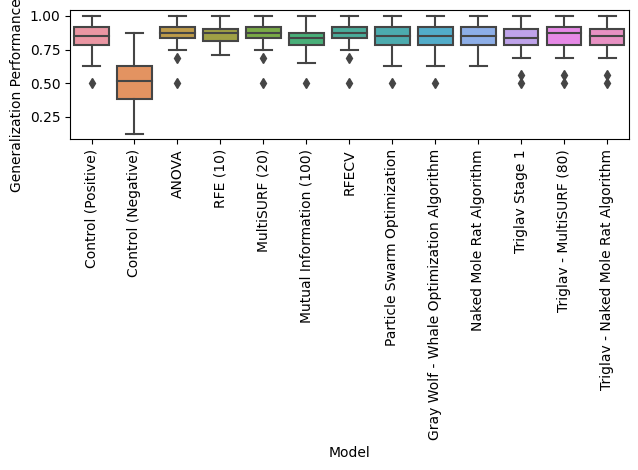

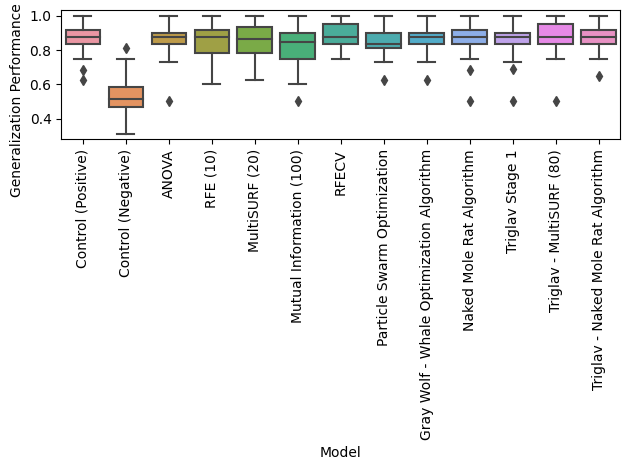

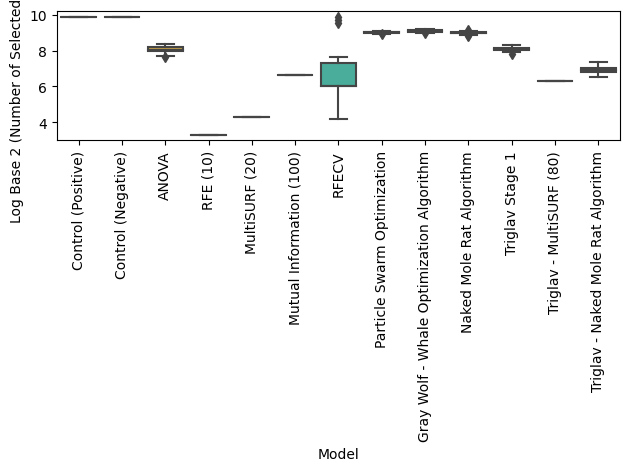

In [220]:
    #arr_final = np.asarray(tmp_base)
    arr_final = pd.read_csv("exp_arr.csv").values[:, 1:-1]
    model_subset = ["Control (Positive)", "Control (Negative)", 
                    "Mutual Information (100)", "ANOVA",
                    "RFE (10)", "RFECV",
                    "Particle Swarm Optimization", "Artificial Bee Colony Optimizaton", "Gray Wolf - Whale Optimization Algorithm", "Naked Mole Rat Algorithm",
                    "MultiSURF (20)", "Triglav Stage 1", "Triglav MultiSURF 80", "Triglav = Naked Mole Rat Algorithm"]
    
    model_ss = [True if x[0] in model_subset else False for x in arr_final]
    
    arr_final = arr_final[model_ss]
    
    exp_arr = pd.DataFrame(np.asarray(tmp_base), columns = ["Model", "Generalization Performance (ETC)", 
                                                            "Generalization Performance (LSVC)", 
                                                            "Features", "Number of Selected Features"], dtype = "object")
    
    exp_arr["Log Base 2 (Number of Selected Features)"] = np.log2(exp_arr["Number of Selected Features"].values.astype(int))
    
    #exp_arr.to_csv("exp_arr.csv")
    
    exp_arr = pd.DataFrame(arr_final, columns = ["Model", "Generalization Performance (ETC)", 
                                                            "Generalization Performance (LSVC)", 
                                                         "Features", "Number of Selected Features"], dtype = "object")
    
    exp_arr["Log Base 2 (Number of Selected Features)"] = np.log2(exp_arr["Number of Selected Features"].values.astype(int))
    
    exp_arr.to_csv("exp_arr_ss.csv")
    
    exp_arr["Model"] = np.where(exp_arr["Model"].values == "Triglav = Naked Mole Rat Algorithm", 
                                "Triglav - Naked Mole Rat Algorithm",
                                exp_arr["Model"].values)
    
    exp_arr["Model"] = np.where(exp_arr["Model"].values == "Triglav MultiSURF 80", 
                                "Triglav - MultiSURF (80)",
                                exp_arr["Model"].values)
    
    ax = sns.boxplot(x = "Model", y = "Generalization Performance (ETC)", hue = "Model", 
                data = exp_arr, dodge = False)
    legend = ax.legend()
    legend.remove()
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    ax = sns.boxplot(x = "Model", y = "Generalization Performance (LSVC)", hue = "Model", 
                     data = exp_arr, dodge = False)
    legend = ax.legend()
    legend.remove()
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    ax = sns.boxplot(x = "Model", y = "Log Base 2 (Number of Selected Features)", hue = "Model", 
                     data = exp_arr, dodge = False)
    legend = ax.legend()
    legend.remove()
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show()
    plt.close()
